# **ĐỒ ÁN CUỐI KỲ MÔN MÁY HỌC**
---
# **Đề tài: Phát hiện tai nạn giao thông**







# ***A. Giới Thiệu***
# **1. Thành viên nhóm:**


1.   Huỳnh Thiện Tùng - 19522492
2.   Lê Thị Thanh Thanh - 19520954
3.   Nguyễn Thành Vương - 19522542

# **2. Mô tả bài toán**

Đây là bài toán phân loại, gồm 2 lớp:
- Tai nạn giao thông.
- Không phải tai nạn giao thông. 

Input & Output:
- Input: 1 tấm ảnh bất kỳ được chụp từ camera giám sát giao thông (*)
- Output: Xác định ảnh có tai nạn hay không có tai nạn.

**(*) Điều kiện ràng buộc:**
1. Ảnh phải có kích thước lớn hơn 224 x 224 pixels.
2. Phải là ảnh liên quan đến giao thông (bắt buộc phải có đường sá).

# ***B. Nội Dung***

Chúng em sẽ thực hiện phân lớp ảnh dựa trên **3** mô hình:
1. Mô hình CNN-SVM (không tăng cường dữ liệu).
2. Mô hình CNN-SVM (có tăng cường dữ liệu).
3. Mô hình dùng kỹ thuật **Transfer Learning**

# **Mô hình CNN-SVM (không tăng cường dữ liệu)**

# 1. Cấp phát GPU

In [ ]:
!nvidia-smi

Sun Aug  8 04:17:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2. Thêm vào các thư viện cần sử dụng.

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image
import PIL
import fnmatch
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

Kiểm tra phiên bản của tensorflow.

In [ ]:
tf.__version__

'2.5.0'

Kiểm tra phiên bản của pillow.

In [ ]:
PIL.__version__

'7.1.2'

# 3. Chuẩn bị dataset.
Dataset được thu thập bởi các thành viên trong nhóm và upload lên google drive. Ta tải dataset về local colab bằng id của file dataset và giải nén.

In [ ]:
!gdown --id 1HnPPhbqhE2vSTJOPq7Z_Ltk12x1WjWpW
!gdown --id 1B9-ceeSceJ3PjkJsnCgIhle1Y_ROUO4e
!unzip "/content/train.zip" -d "/content/train"
!unzip "/content/test.zip" -d "/content/test"

Downloading...
From: https://drive.google.com/uc?id=1HnPPhbqhE2vSTJOPq7Z_Ltk12x1WjWpW
To: /content/test.zip
41.9MB [00:00, 115MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1B9-ceeSceJ3PjkJsnCgIhle1Y_ROUO4e
To: /content/train.zip
355MB [00:02, 122MB/s]
Archive:  /content/train.zip
   creating: /content/train/accidents/
  inflating: /content/train/accidents/accident_1.jpg  
  inflating: /content/train/accidents/accident_10.jpg  
  inflating: /content/train/accidents/accident_100.jpg  
  inflating: /content/train/accidents/accident_1000.jpg  
  inflating: /content/train/accidents/accident_1001.jpg  
  inflating: /content/train/accidents/accident_1002.jpg  
  inflating: /content/train/accidents/accident_1003.jpg  
  inflating: /content/train/accidents/accident_1004.jpg  
  inflating: /content/train/accidents/accident_1005.jpg  
  inflating: /content/train/accidents/accident_1006.jpg  
  inflating: /content/train/accidents/accident_1007.jpg  
  inflating: /content/train/acciden

#4. Trực quan dữ liệu 

Ta viết 1 hàm (showData) để thuận tiện cho việc trực quan dataset.

In [ ]:
def showData(dir):
  directory = dir
  total_IMG = len(os.listdir(dir))
  total_jpg = len(fnmatch.filter(os.listdir(directory),'*.jpg'))
  total_png = len(fnmatch.filter(os.listdir(directory),'*.png'))
  total_other = total_IMG - (total_jpg + total_png)
  plt.bar(["JPGE", "PNG", "Other"] ,[total_jpg, total_png, total_other], width=0.5)
  plt.title("Detail about accident images")
  plt.xlabel('Type image format')
  plt.ylabel('Total images')
  plt.show()

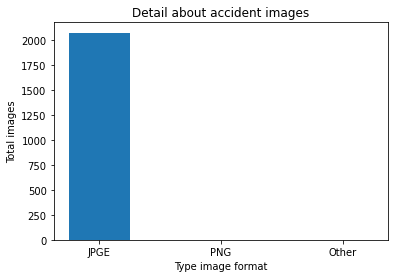

In [ ]:
directory = "/content/train/accidents"
showData(directory)

Như hình ở trên đã thể hiện, 100%  dữ liệu của lớp tai nạn giao thông  là ảnh và tất cả đều có định dạng JPGE.

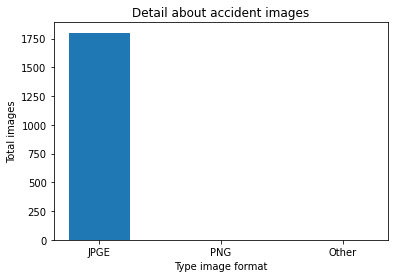

In [ ]:
directory = "/content/train/non-accidents"
showData(directory)

Như hình trên đã thể hiện, 100% dữ liệu của lớp không tai nạn giao thông là ảnh và tất cả đều có định dạng JPGE.

Total train images:  3875
Total test images:  432


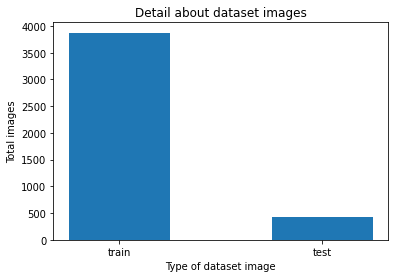

In [ ]:
totalDir = 0
total_train = 0

for base, dirs, files in os.walk("/content/train"):
    for directories in dirs:
        totalDir += 1
    for Files in files:
        total_train += 1

total_test = len(os.listdir("/content/test"))

print("Total train images: ",total_train)
print("Total test images: ",total_test)

plt.bar(["train", "test"] ,[total_train, total_test], width=0.5)
plt.title("Detail about dataset images")
plt.xlabel('Type of dataset image')
plt.ylabel('Total images')
plt.show()

Tổng quan số lượng ảnh của tập train và tập test.

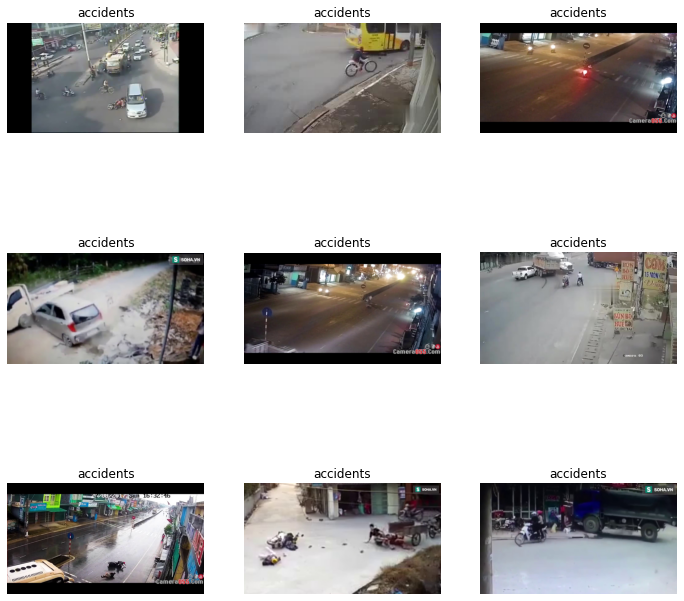

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = matplotlib.image.imread("/content/train/accidents/accident_"+str(i+1)+".jpg")
  plt.imshow(img)
  plt.title("accidents")
  plt.axis("off")

Một số hình ảnh trong tập dữ liệu thuộc lớp tai nạn giao thông.

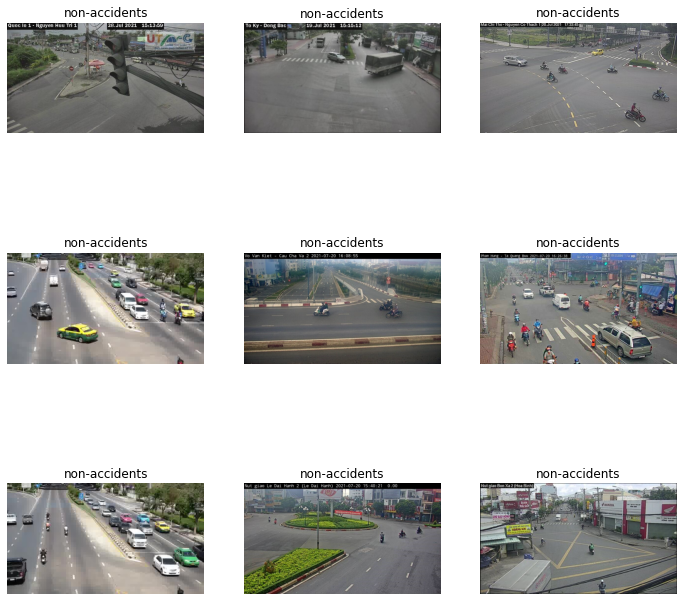

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = matplotlib.image.imread("/content/train/non-accidents/non_accident_"+str(i+1)+".jpg")
  plt.imshow(img)
  plt.title("non-accidents")
  plt.axis("off")

Một số hình ảnh trong tập dữ liệu thuộc lớp không tai nạn giao thông.

# 5. Xây dựng mô hình

In [ ]:
data_root = ("/content/train/")
IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels
TRAINING_DATA_DIR = str(data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

Ta tạo 1 biến lữu trữ đường dẫn đến thư mục dataset thiết lập kích thước ảnh đầu vào là 224 x 224 pixels. Biến datagen_kwargs đóng vai trò là 1 dictionary lưu trữ thiết lập trong quá trình generate tập train và valid.

In [ ]:
# Part 1 - Data Preprocessing
train_datagen = ImageDataGenerator(**datagen_kwargs)

# Preprocessing the Training set
training_set = train_datagen.flow_from_directory(TRAINING_DATA_DIR, subset="training", 
                                                 shuffle=False, target_size=IMAGE_SHAPE, 
                                                 class_mode='binary', batch_size=32)

Found 3101 images belonging to 2 classes.


Ta chia dữ liệu từ từ dataset theo tỉ lệ 8/2, tức là 80% là của tập train và 20% còn lại là của tập valid

In [ ]:
# Preprocessing the Test set
valid_datagen = ImageDataGenerator(**datagen_kwargs)
test_set = valid_datagen.flow_from_directory(TRAINING_DATA_DIR, subset="validation", 
                                             shuffle=False, target_size=IMAGE_SHAPE, 
                                             class_mode='binary', batch_size=32)

Found 774 images belonging to 2 classes.


Sau khi hoàn tất xử lý tập dữ liệu. Ta tiến hành khởi tạo mô hình và xây dựng các lớp (layers) cho mô hình.

In [ ]:
# Part 2 - Building the CNN

# Initialising the CNN
model = tf.keras.models.Sequential()

# Step 1 - Convolution
model.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[224, 224, 3]))

# Step 2 - Pooling
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
model.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
model.add(tf.keras.layers.Flatten()) 

# Step 4 - Full Connection
model.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
model.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='linear'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

Vì là mô hình tự train và các layers được xây dựng thủ công nên tất cả các tham số được trích xuất từ ảnh mô hình đều học được (***trainable params***). Tiếp theo, chúng ta cần định nghĩa hàm ***Loss function*** và ***Optimization Algorithms*** với việc sử dụng hàm ***.compile()*** như sau: 

In [ ]:
# Part 3 - Training the CNN

# Compiling the CNN
model.compile(optimizer='adam', loss='hinge', metrics=['acc'])

# Stop training if 'val_loss' stops improving for over 10 epochs <=> Fix Overfitting problem
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)

# Save the best model to .h5 file
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',save_best_only=True,verbose=1)

r=model.fit(x = training_set, validation_data = test_set, epochs = 20, callbacks=[early_stopping,best_model])

Epoch 1/20
97/97 [==============================] - 84s 857ms/step - loss: 0.9868 - acc: 0.6472 - val_loss: 0.4820 - val_acc: 0.7455

Epoch 00001: val_loss improved from inf to 0.48198, saving model to best_model.h5
Epoch 2/20
97/97 [==============================] - 81s 828ms/step - loss: 0.4750 - acc: 0.8617 - val_loss: 0.2289 - val_acc: 0.8824

Epoch 00002: val_loss improved from 0.48198 to 0.22886, saving model to best_model.h5
Epoch 3/20
97/97 [==============================] - 81s 831ms/step - loss: 0.1081 - acc: 0.9487 - val_loss: 0.1089 - val_acc: 0.9548

Epoch 00003: val_loss improved from 0.22886 to 0.10893, saving model to best_model.h5
Epoch 4/20
97/97 [==============================] - 81s 832ms/step - loss: 0.0397 - acc: 0.9810 - val_loss: 0.0662 - val_acc: 0.9664

Epoch 00004: val_loss improved from 0.10893 to 0.06623, saving model to best_model.h5
Epoch 5/20
97/97 [==============================] - 80s 828ms/step - loss: 0.0201 - acc: 0.9913 - val_loss: 0.0532 - val_acc

Trong quá trình train mô hình, chúng em sử dụng 1 trong những phương pháp làm ***giảm tỉ lệ overfitting***, đó là phương pháp ***early stopping***. Khi giá trị ***val_loss*** không cải thiện qua 5 epoch (có thể thiết lập lại số khác), mô hình sẽ ngừng train và thông báo **"early stopping"** (tức là nhận thấy mô hình bắt đầu ***overfitting***) ngược lại khi ***val_loss*** cải thiện thì lưu mô hình đó lại để dùng dự đoán tập test (best model).

Ở đây, tại epoch thứ 13, đã xảy ra early stopping sau khi 5 epoch trước đó không có dấu hiệu cải thiện ***val loss***. Mô hình tốt nhất tại epoch thứ 8 đã được lưu lại với tên ***best_model.h5***

Ta tiến hành load mô hình tốt nhất sau khi đã train (file ***best_model.h5***).

In [ ]:
# Load the best model
try:
  model = keras.models.load_model(filepath="/content/best_model.h5")
  print("Load Model Successfully!")
except:
  print("Failed to load model! Please check again!")

Load Model Successfully!


Sử dụng hàm ***.evaluate()*** để đánh giá valid set

In [ ]:
final_loss, final_accuracy = model.evaluate(test_set)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

25/25 [==============================] - 11s 434ms/step - loss: 0.0211 - acc: 0.9884
Final loss: 0.02
Final accuracy: 98.84%


# 6. Trực quan mô hình
Ta tiến hành trực quan ***đồ thị loss*** và ***đồ thị accuracy*** sau khi đã train, thông qua thư viện matplotlib. Đây cũng chính là yếu tố để đánh giá mô hình tốt hay tệ. 

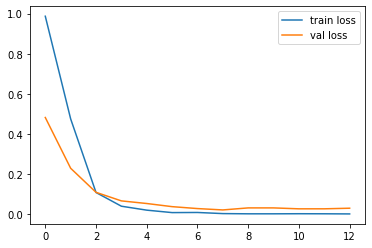

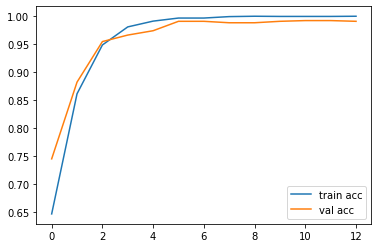

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

Nhận xét chỗ này

# 7. Dự đoán của mô hình trên tập test

Total correct prediction:  431
Total incorrect prediction:  1


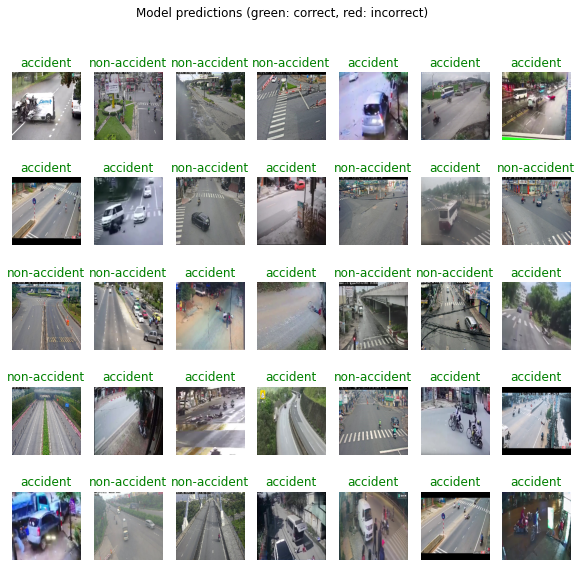

In [ ]:
prePath = "/content/test/"
test_ = random.sample(os.listdir(prePath),total_test)
random.shuffle(test_)
false_ = []

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for _ in range(len(test_)):
  if _ < 35:
    plt.subplot(5, 7, _+1)
  true_label_ = len(test_[_].split("_"))
  img_= image.load_img(prePath + test_[_], target_size = (224,224))
  if _ < 35:
    plt.imshow(img_)
  img_ = image.img_to_array(img_)
  img_= img_/255
  img_ = np.expand_dims(img_, axis = 0)
  pre_ = 2 if model.predict(img_) < 0 else 3
  if pre_ == true_label_:
    color = "green"
  else:
    color = "red"
    false_.append(prePath + test_[_])
  plt.title("accident" if pre_ == 2 else "non-accident", color=color)
  plt.axis('off')
  plt.suptitle("Model predictions (green: correct, red: incorrect)")
print("Total correct prediction: ",total_test-len(false_))
print("Total incorrect prediction: ",len(false_))

Mô hình dự đoán đúng ***431/432*** tấm ảnh, đạt tỉ lệ chính xác ***99,77%***

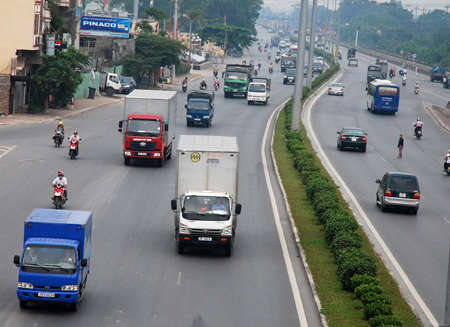

In [ ]:
if len(false_) > 0:
  for img in false_:  
    display(Image(img, width = 512, height = 512))

Tất cả hình ảnh mà mô hình dự đoán sai.

# **Mô hình CNN-SVM (có tăng cường dữ liệu)**

# 1. Tăng cường dữ liệu và xây dựng mô hình

Ta tiến hành tăng cường dữ liệu bằng các phương pháp như phóng to ảnh, lật ảnh, xoay ảnh, ... và ta chỉ tiến hành tăng cường dữ liệu trên tập train.

In [ ]:
# Part 1 - Data Preprocessing
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Preprocessing the Training set
training_set = train_datagen.flow_from_directory(TRAINING_DATA_DIR, subset="training", 
                                                 shuffle=False, target_size=IMAGE_SHAPE, 
                                                 class_mode='binary', batch_size=32)

valid_datagen = ImageDataGenerator(**datagen_kwargs)
test_set = valid_datagen.flow_from_directory(TRAINING_DATA_DIR, subset="validation", 
                                             shuffle=False, target_size=IMAGE_SHAPE, 
                                             class_mode='binary', batch_size=32)

Found 3101 images belonging to 2 classes.
Found 774 images belonging to 2 classes.


Xây dựng các lớp cho mô hình

In [ ]:
# Part 2 - Building the CNN

# Initialising the CNN
model = tf.keras.models.Sequential()

# Step 1 - Convolution
model.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[224, 224, 3]))

# Step 2 - Pooling
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
model.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
model.add(tf.keras.layers.Flatten()) 

# Step 4 - Full Connection
model.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
model.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

Tiếp đến, ta train model sau khi đã xây dựng xong các lớp cần thiết của mô hình.

In [ ]:
# Part 3 - Training the CNN

# Compiling the CNN
model.compile(optimizer='adam', loss='hinge', metrics=['acc'])

# Stop training if 'val_loss' stops improving for over 10 epochs <=> Fix Overfitting problem
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)

# Save the best model to .h5 file
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model2.h5',monitor='val_loss',save_best_only=True,verbose=1)

r=model.fit(x = training_set, validation_data = test_set, epochs = 20, callbacks=[early_stopping,best_model])

Epoch 1/20
97/97 [==============================] - 111s 1s/step - loss: 0.9907 - acc: 0.5685 - val_loss: 1.0784 - val_acc: 0.5659

Epoch 00001: val_loss improved from inf to 1.07843, saving model to best_model2.h5
Epoch 2/20
97/97 [==============================] - 109s 1s/step - loss: 0.7653 - acc: 0.6791 - val_loss: 0.5962 - val_acc: 0.8075

Epoch 00002: val_loss improved from 1.07843 to 0.59624, saving model to best_model2.h5
Epoch 3/20
97/97 [==============================] - 109s 1s/step - loss: 0.6080 - acc: 0.7420 - val_loss: 0.3975 - val_acc: 0.8669

Epoch 00003: val_loss improved from 0.59624 to 0.39755, saving model to best_model2.h5
Epoch 4/20
97/97 [==============================] - 109s 1s/step - loss: 0.5499 - acc: 0.7585 - val_loss: 0.3091 - val_acc: 0.8656

Epoch 00004: val_loss improved from 0.39755 to 0.30912, saving model to best_model2.h5
Epoch 5/20
97/97 [==============================] - 109s 1s/step - loss: 0.5193 - acc: 0.7594 - val_loss: 0.4019 - val_acc: 0.87

Load mô hình tốt nhất để dự đoán tập test.

In [ ]:
# Load the best model
try:
  model = keras.models.load_model(filepath="/content/best_model2.h5")
  print("Load Model Successfully!")
except:
  print("Failed to load model! Please check again!")

Load Model Successfully!


Đánh giá mô hình trên tập valid

In [ ]:
final_loss, final_accuracy = model.evaluate(test_set)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

25/25 [==============================] - 11s 425ms/step - loss: 0.0605 - acc: 0.9767
Final loss: 0.06
Final accuracy: 97.67%


# 2. Trực quan mô hình

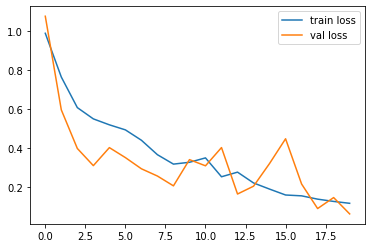

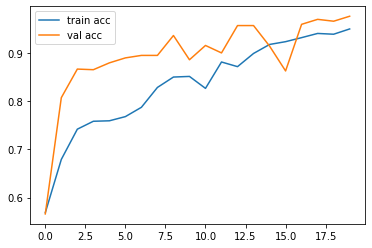

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss_2')

# plot the accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc_2')

# Dự đoán của mô hình trên tập test

Total correct prediction:  421
Total incorrect prediction:  11


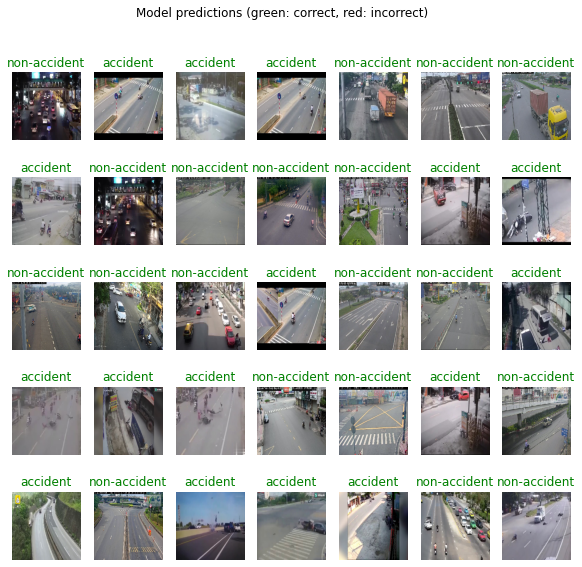

In [ ]:
prePath = "/content/test/"
test_ = random.sample(os.listdir(prePath),total_test)
random.shuffle(test_)
false_ = []

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for _ in range(len(test_)):
  if _ < 35:
    plt.subplot(5, 7, _+1)
  true_label_ = len(test_[_].split("_"))
  img_= image.load_img(prePath + test_[_], target_size = (224,224))
  if _ < 35:
    plt.imshow(img_)
  img_ = image.img_to_array(img_)
  img_= img_/255
  img_ = np.expand_dims(img_, axis = 0)
  pre_ = 2 if model.predict(img_) < 0 else 3
  if pre_ == true_label_:
    color = "green"
  else:
    color = "red"
    false_.append(prePath + test_[_])
  plt.title("accident" if pre_ == 2 else "non-accident", color=color)
  plt.axis('off')
  plt.suptitle("Model predictions (green: correct, red: incorrect)")
print("Total correct prediction: ",total_test-len(false_))
print("Total incorrect prediction: ",len(false_))

# Hiển thị các ảnh dự đoán sai

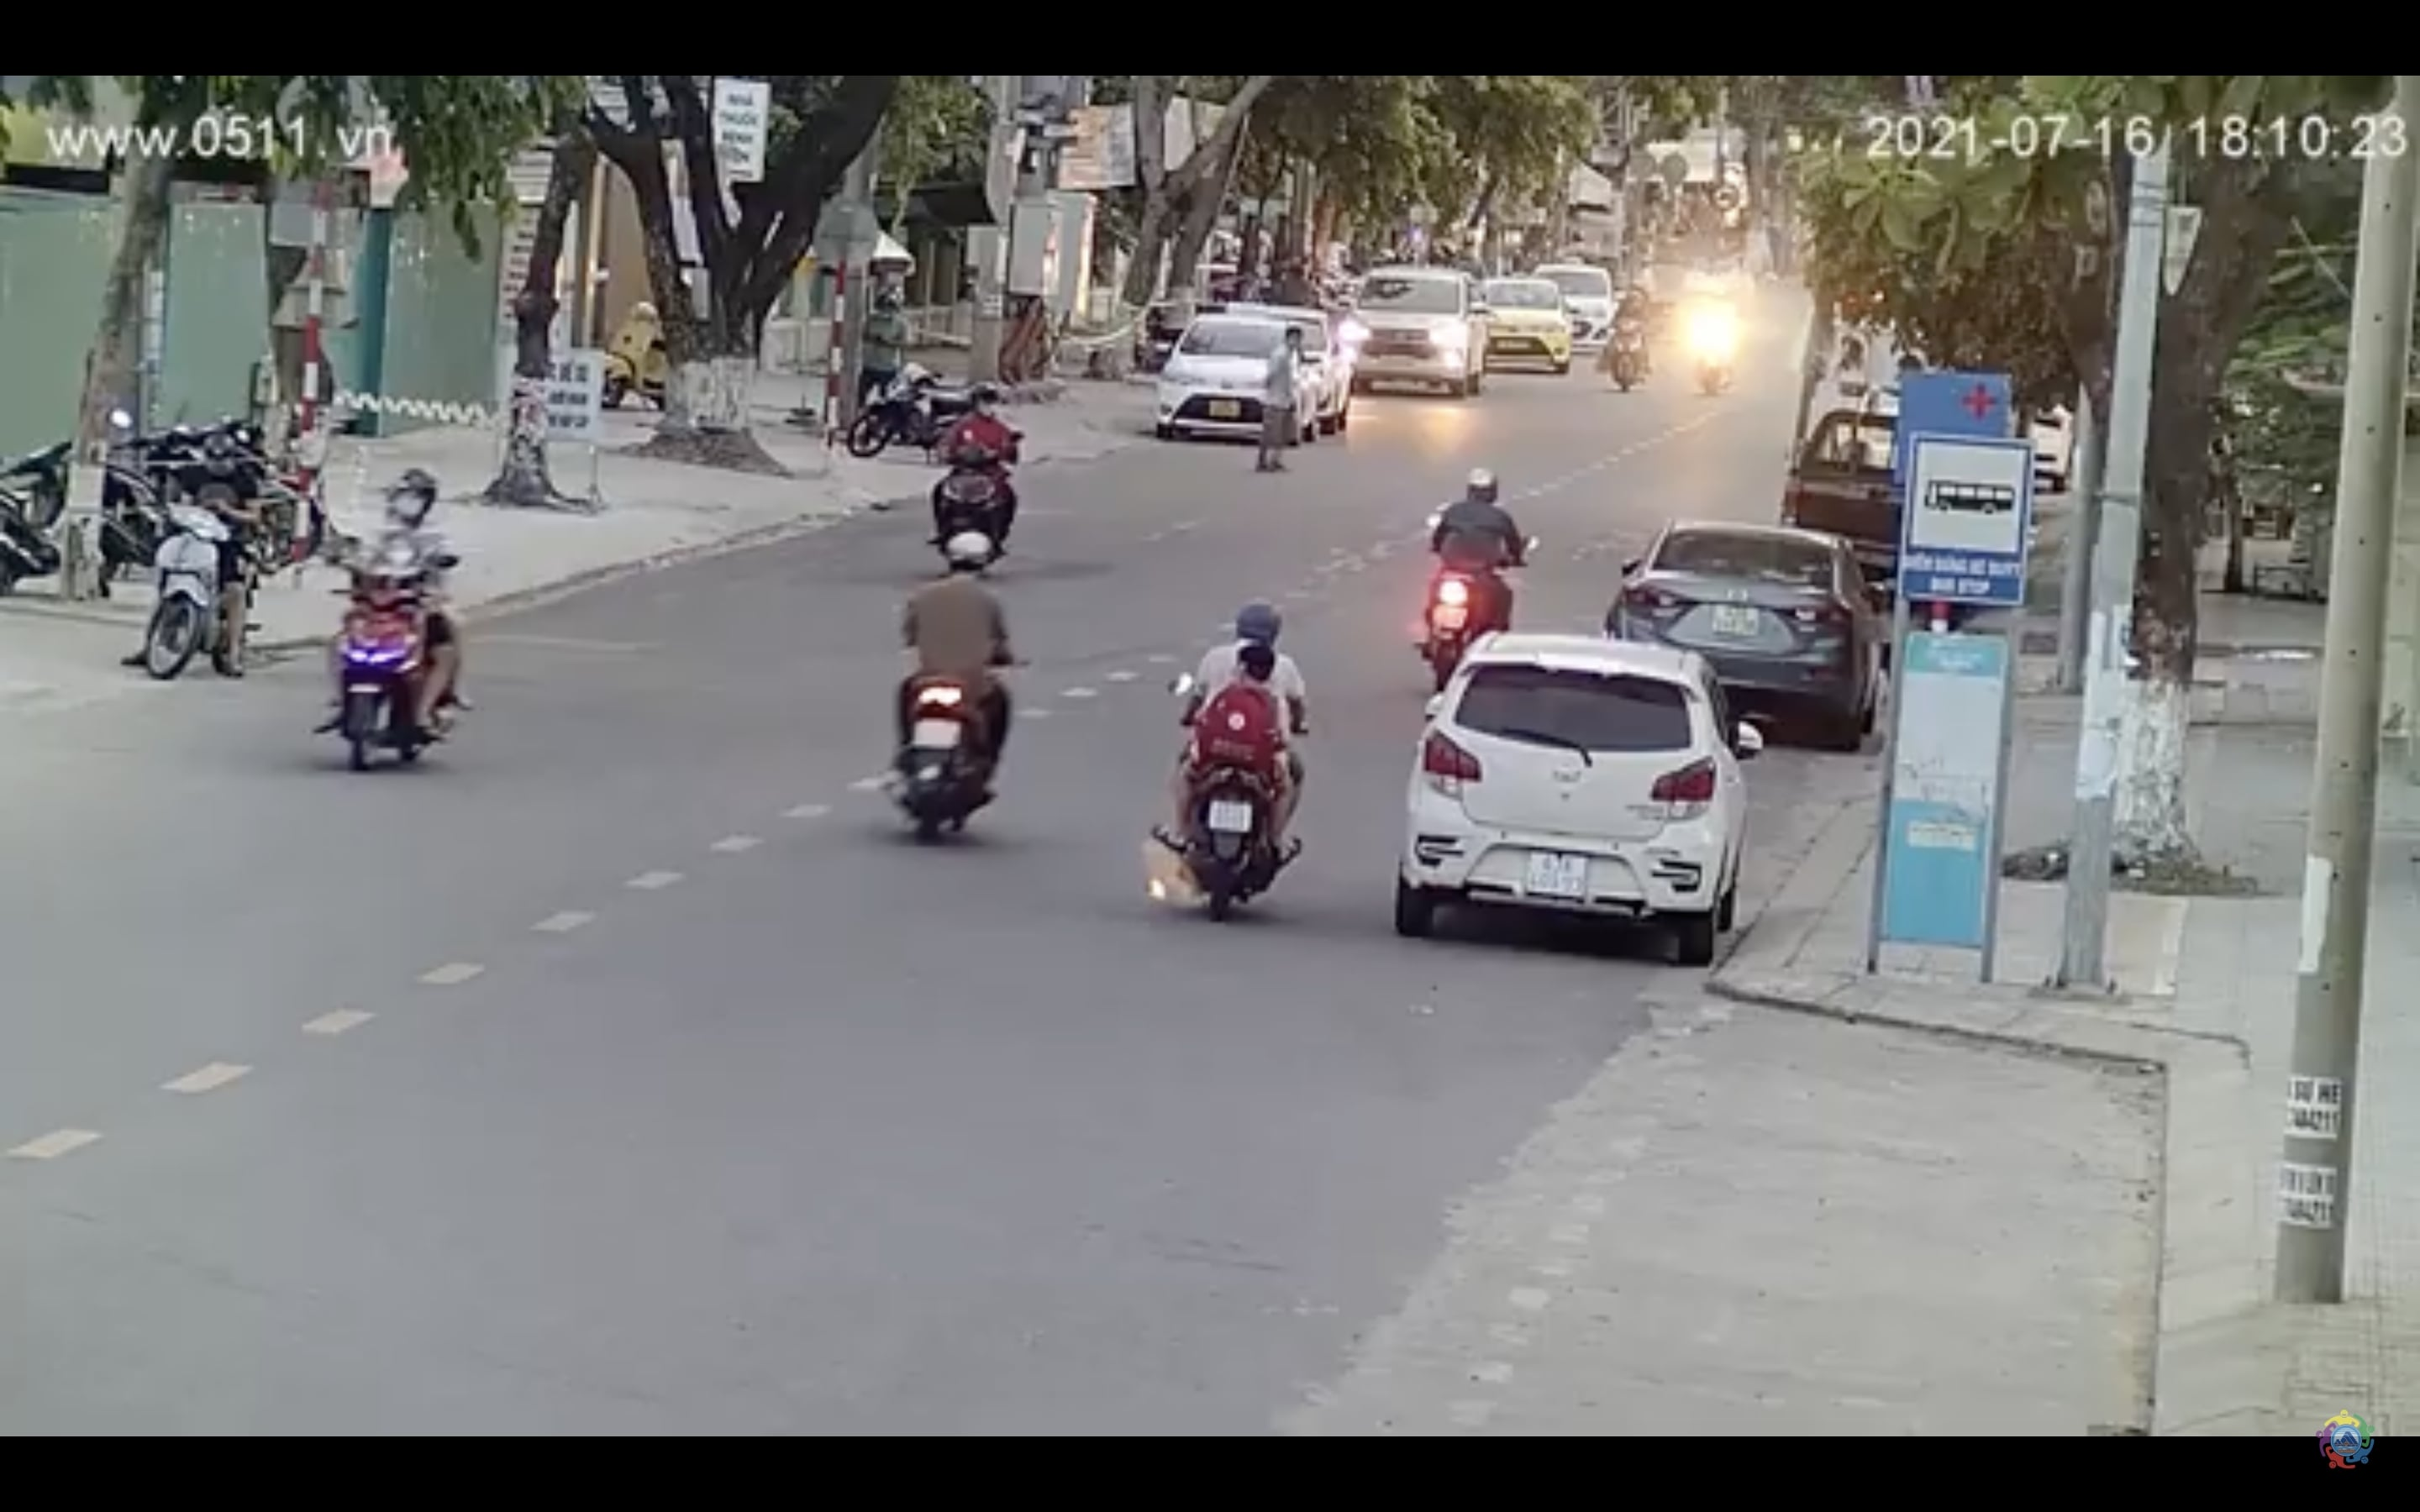

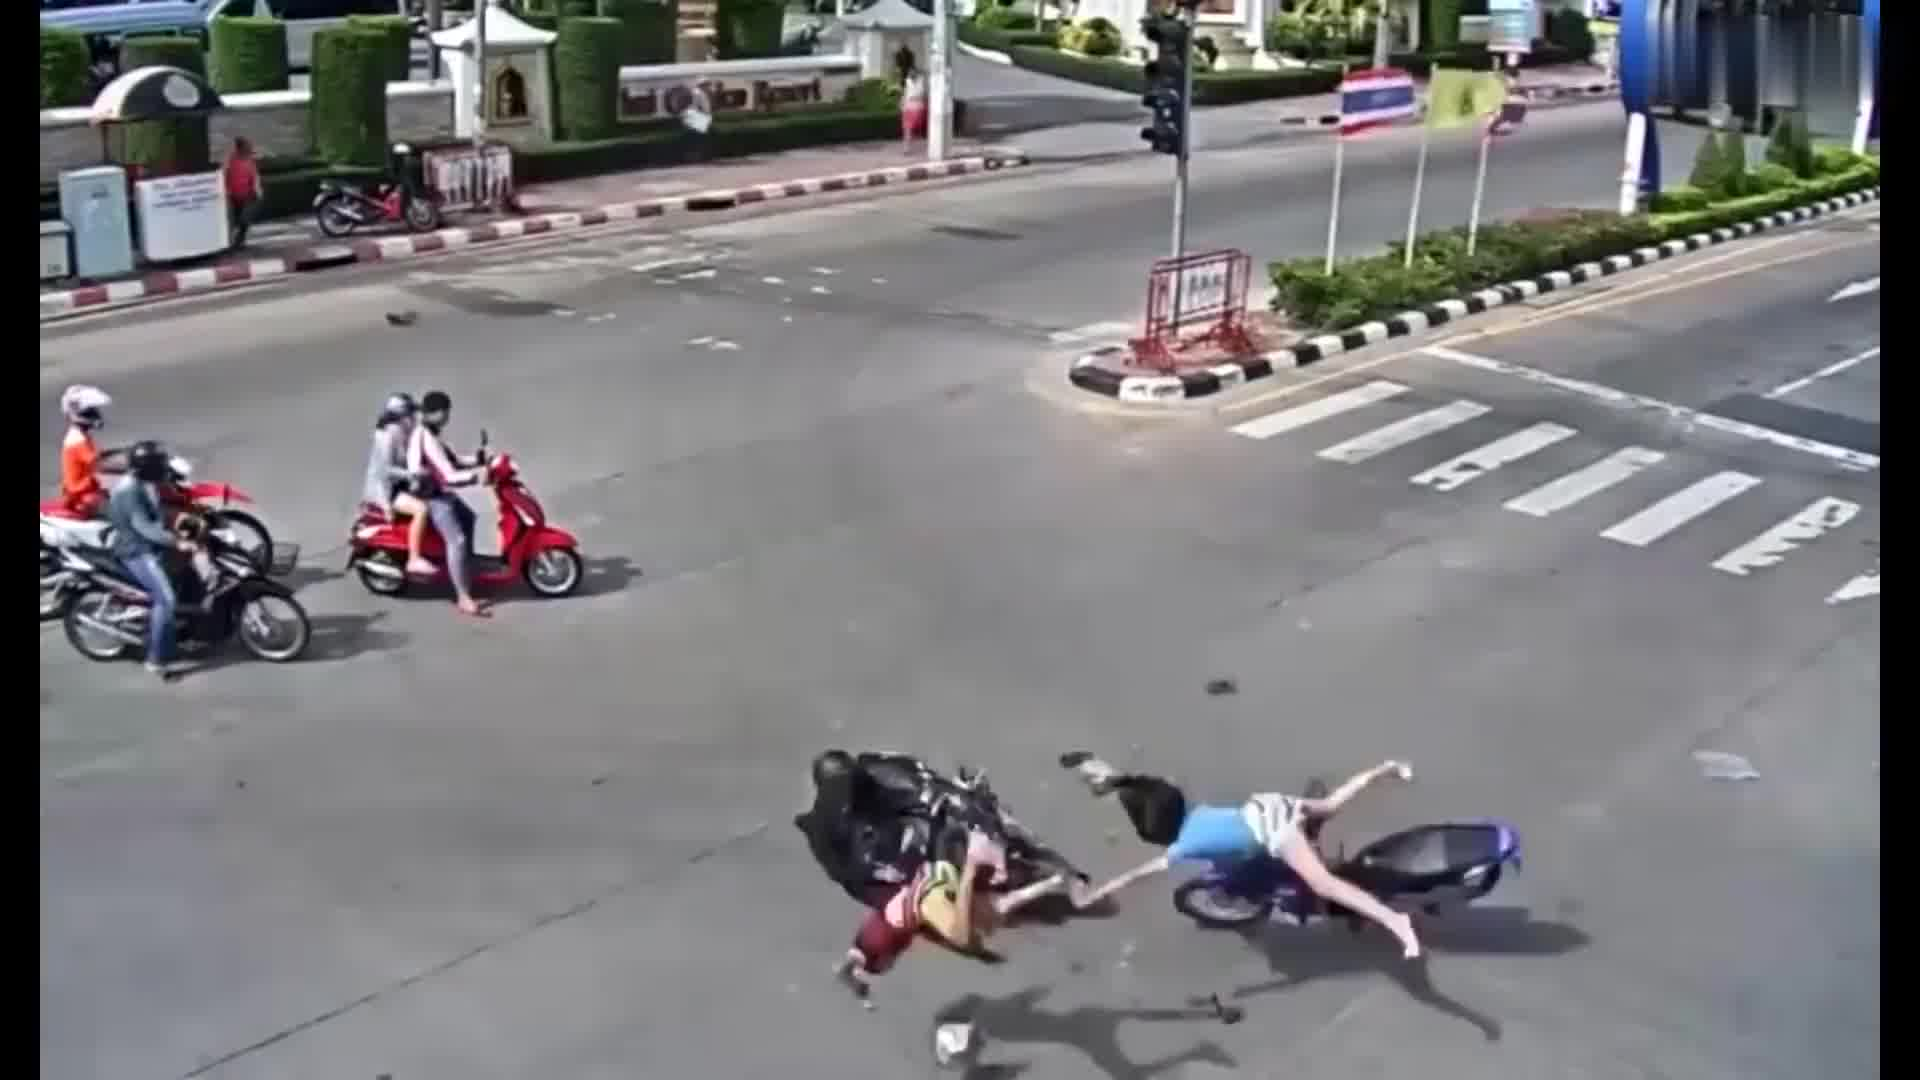

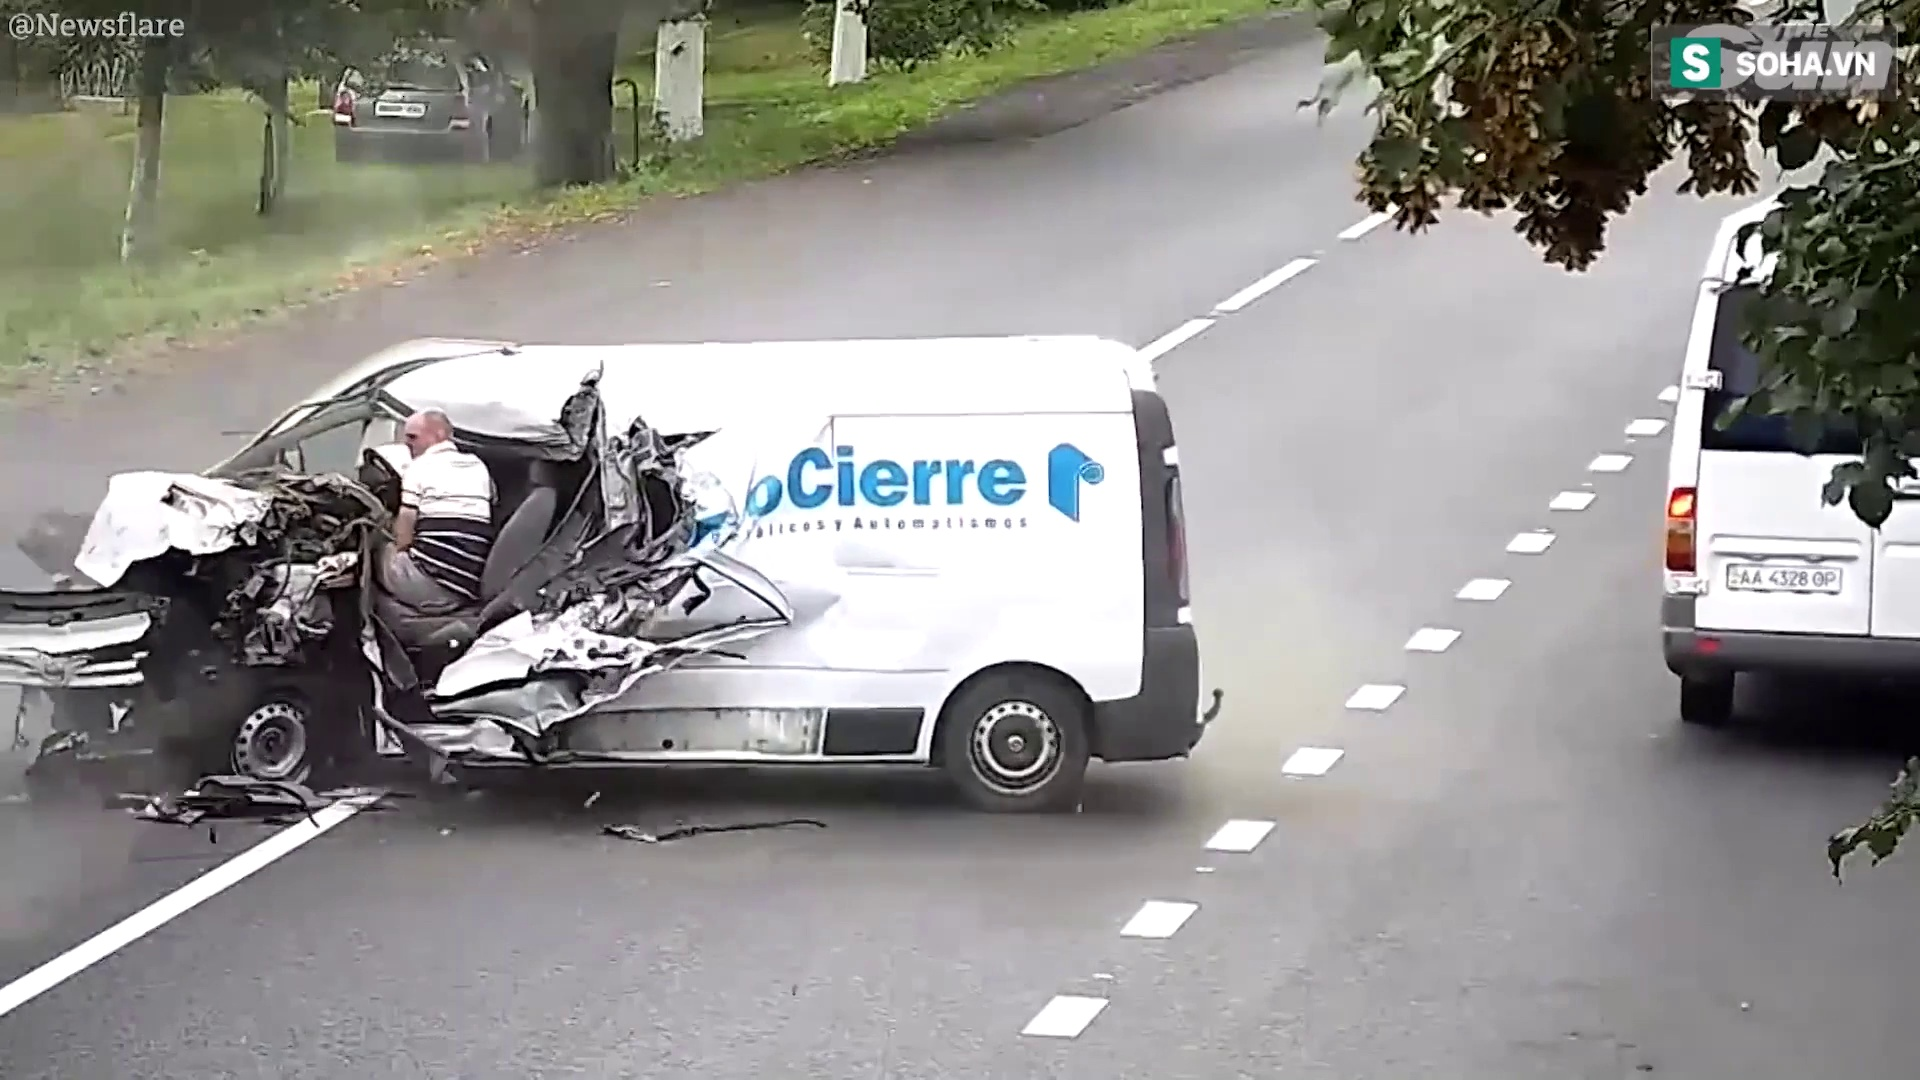

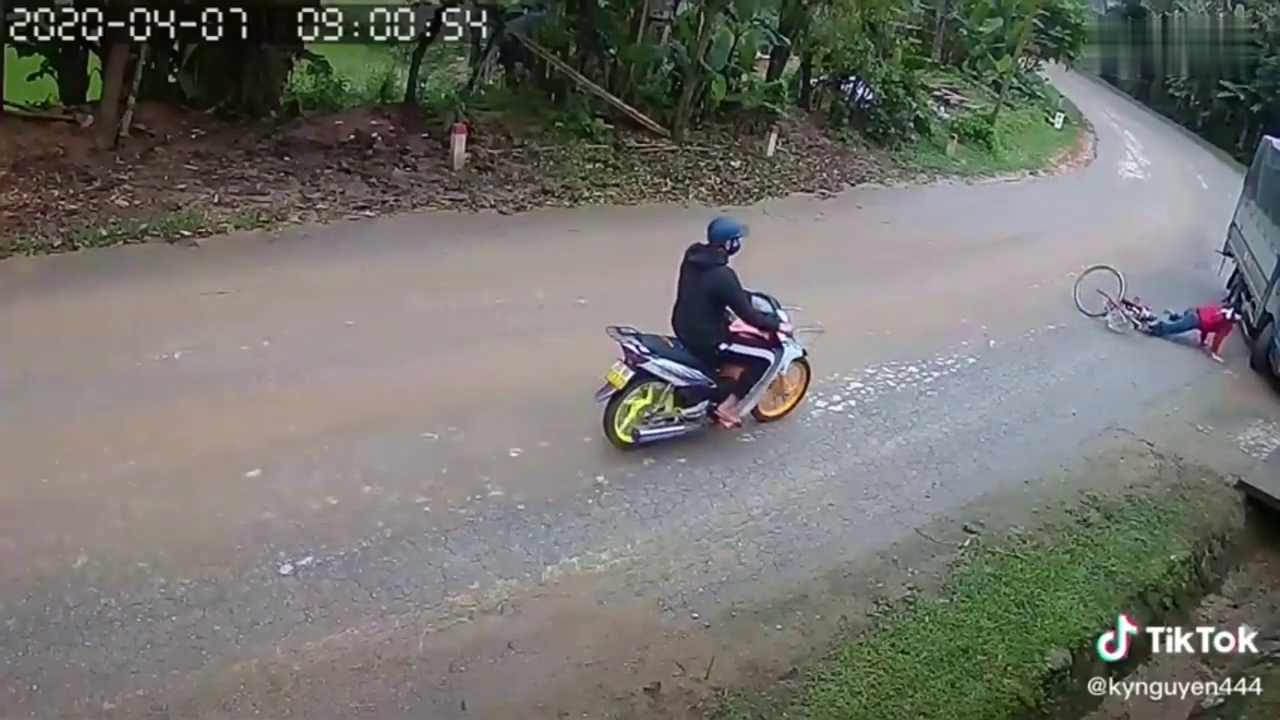

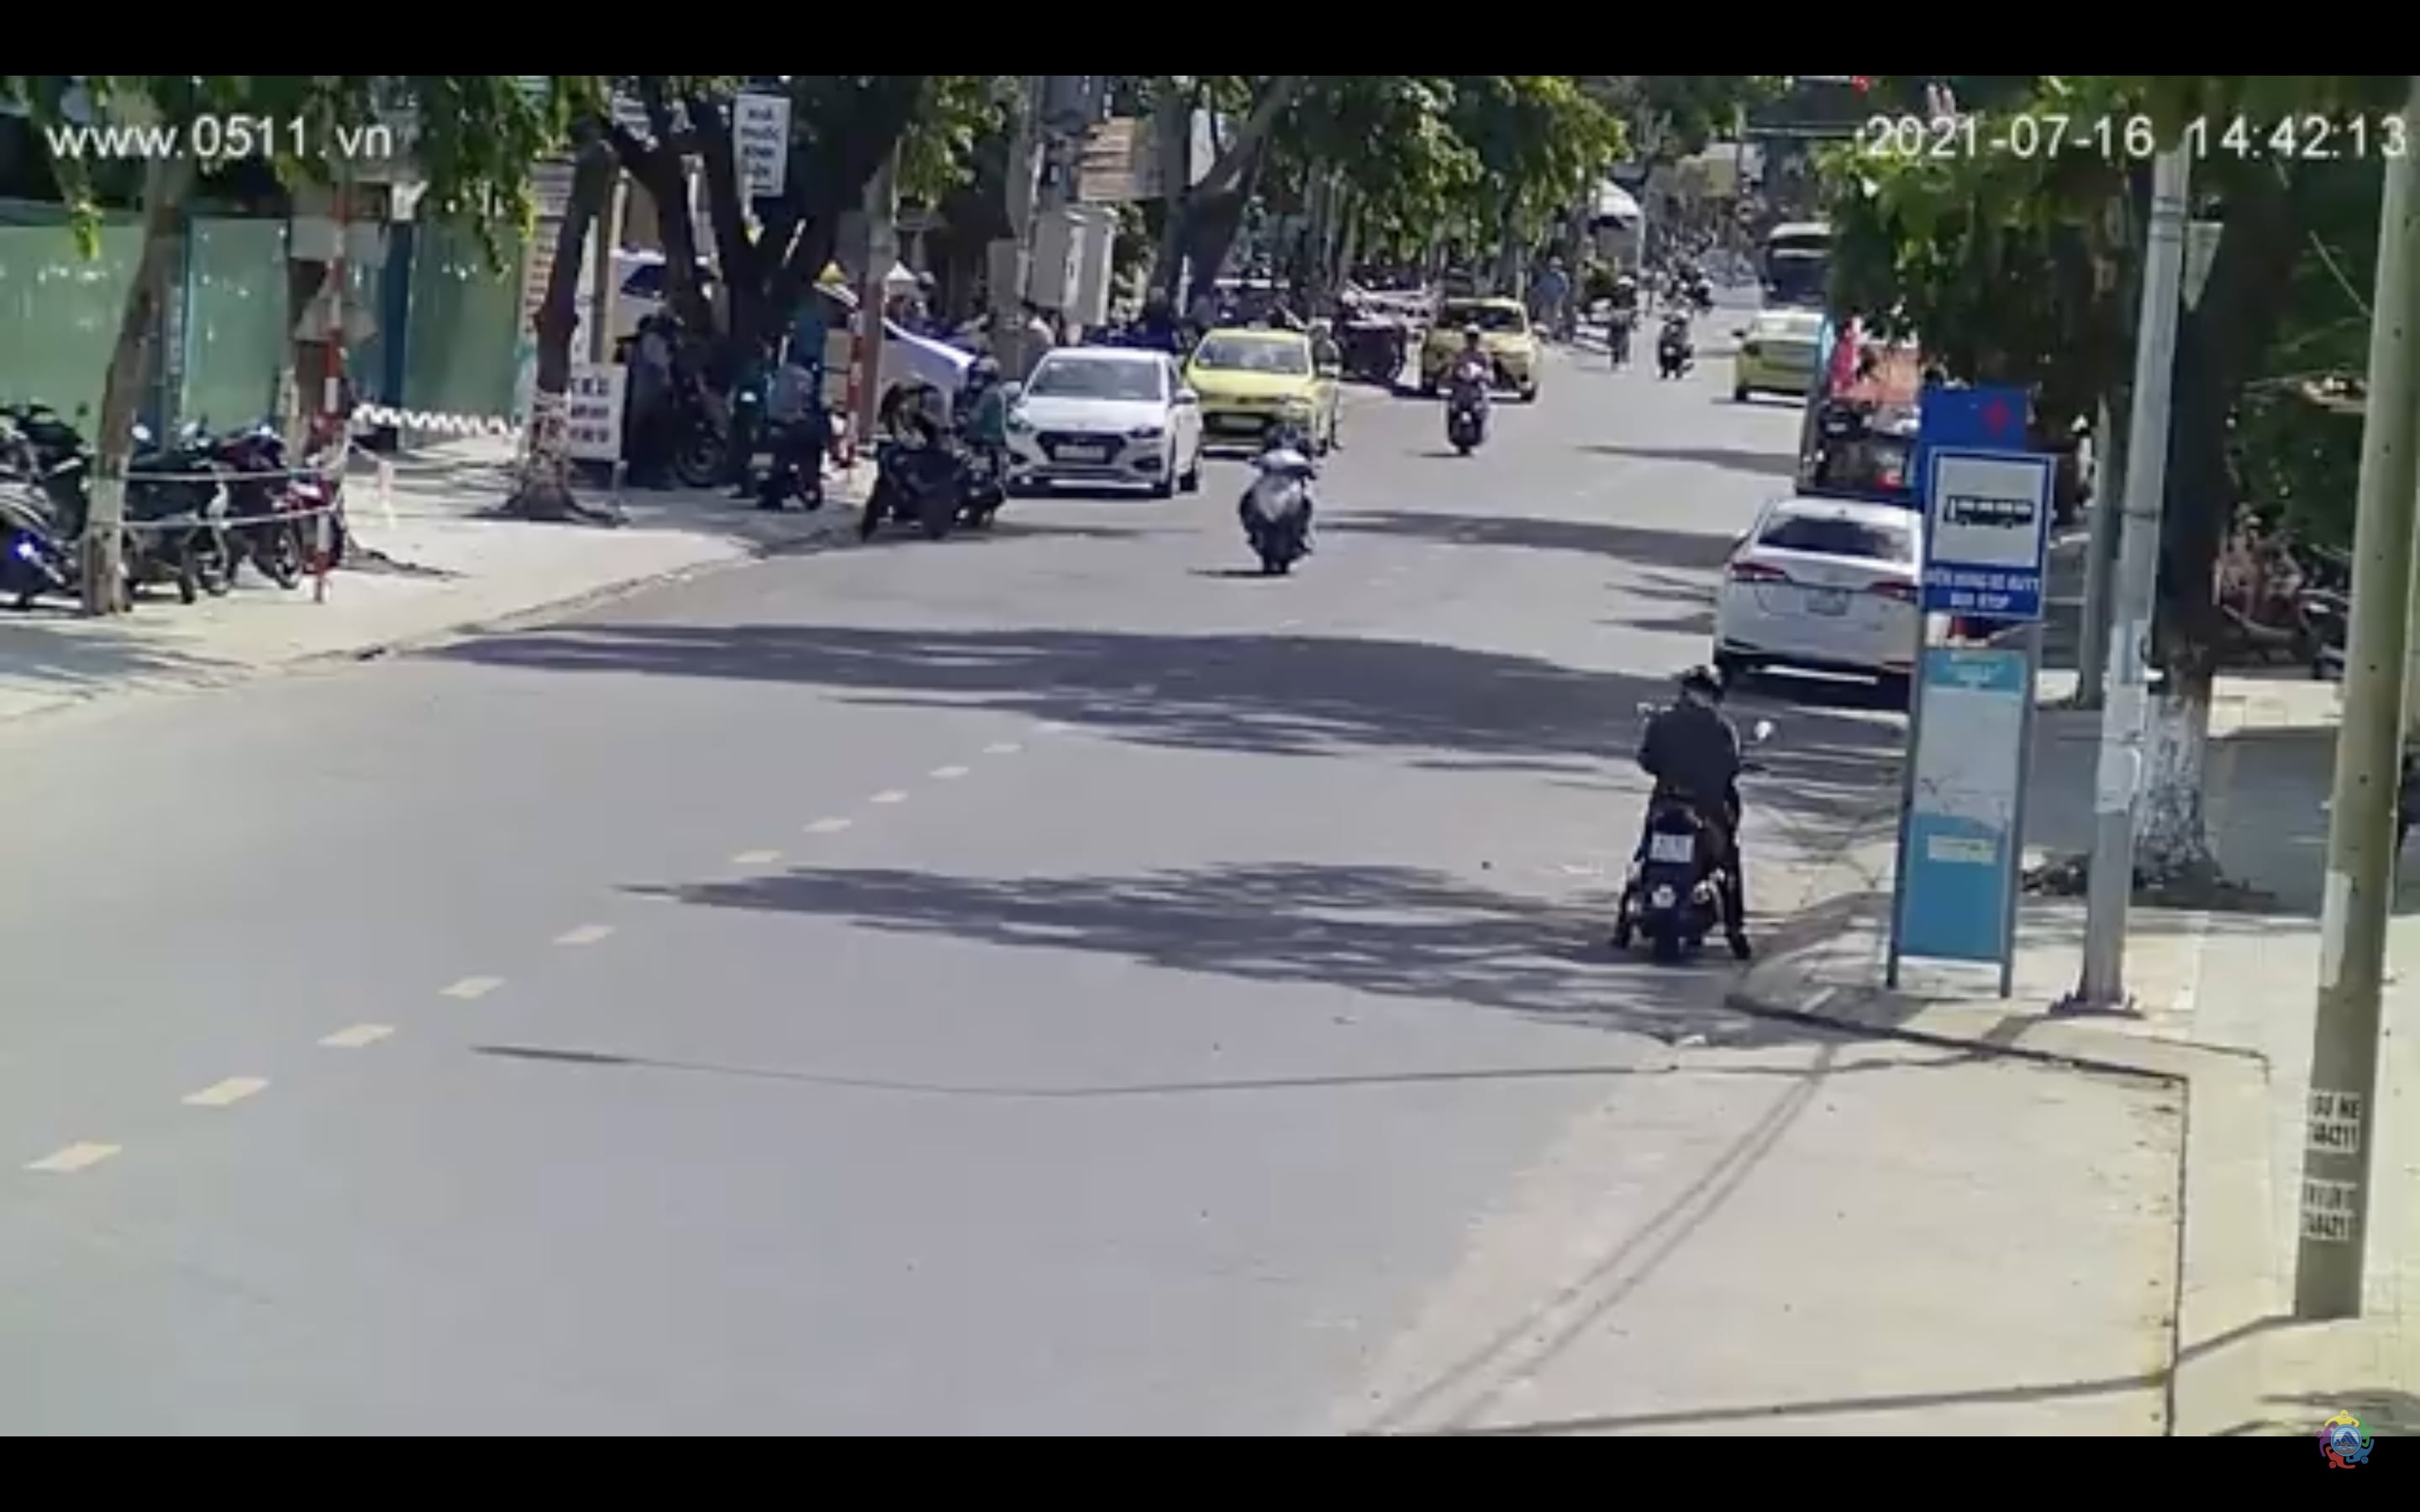

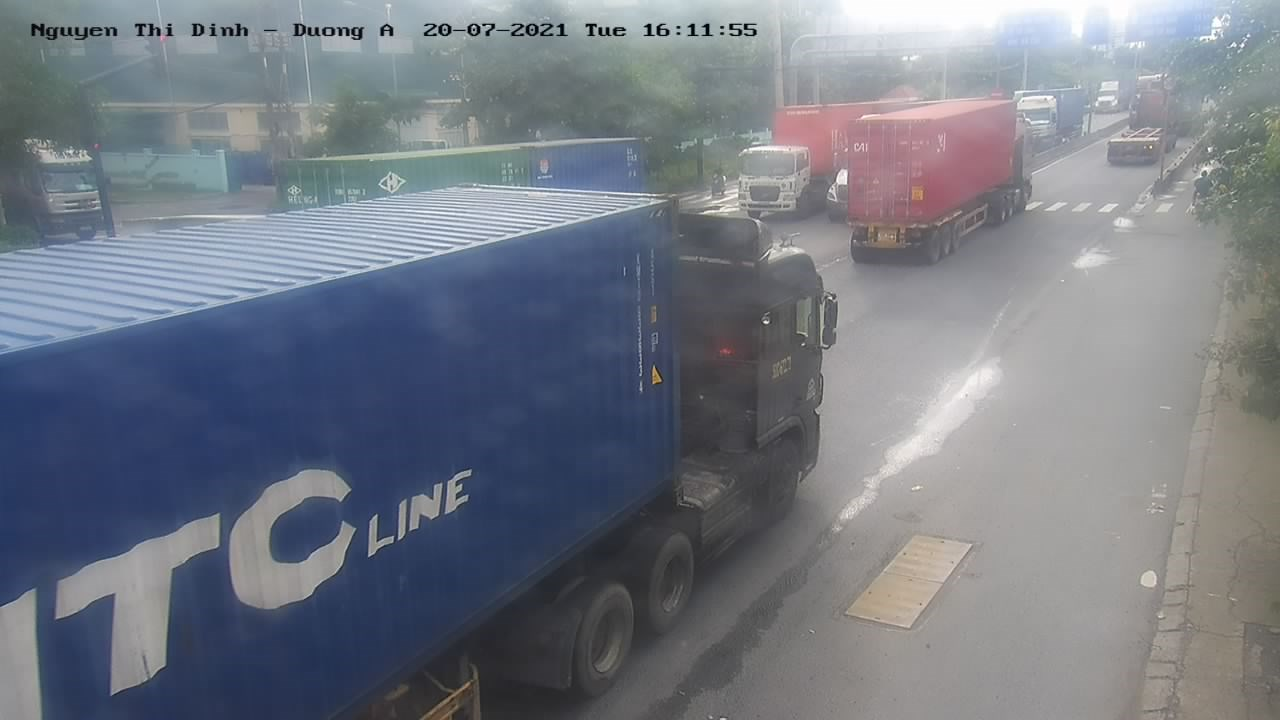

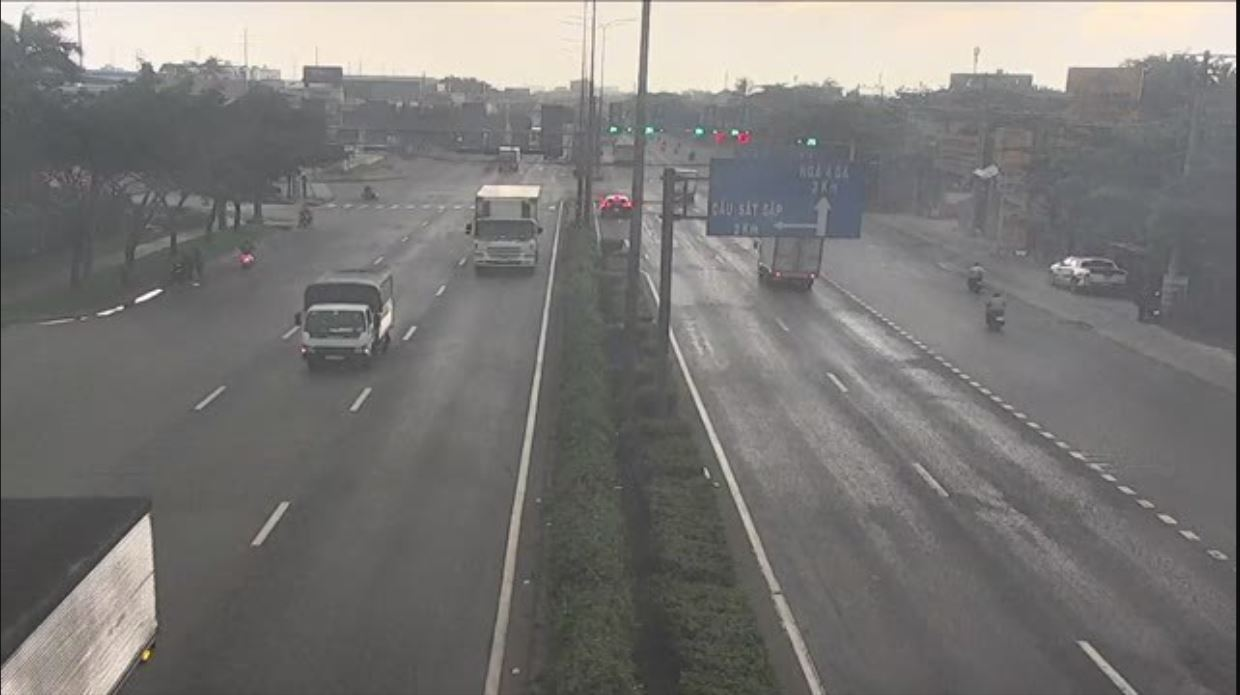

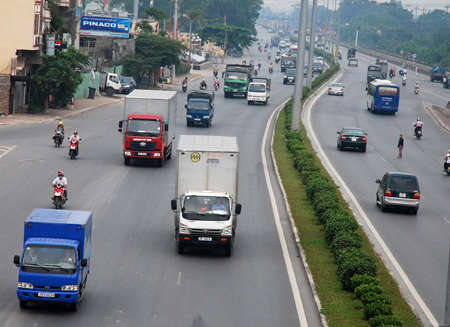

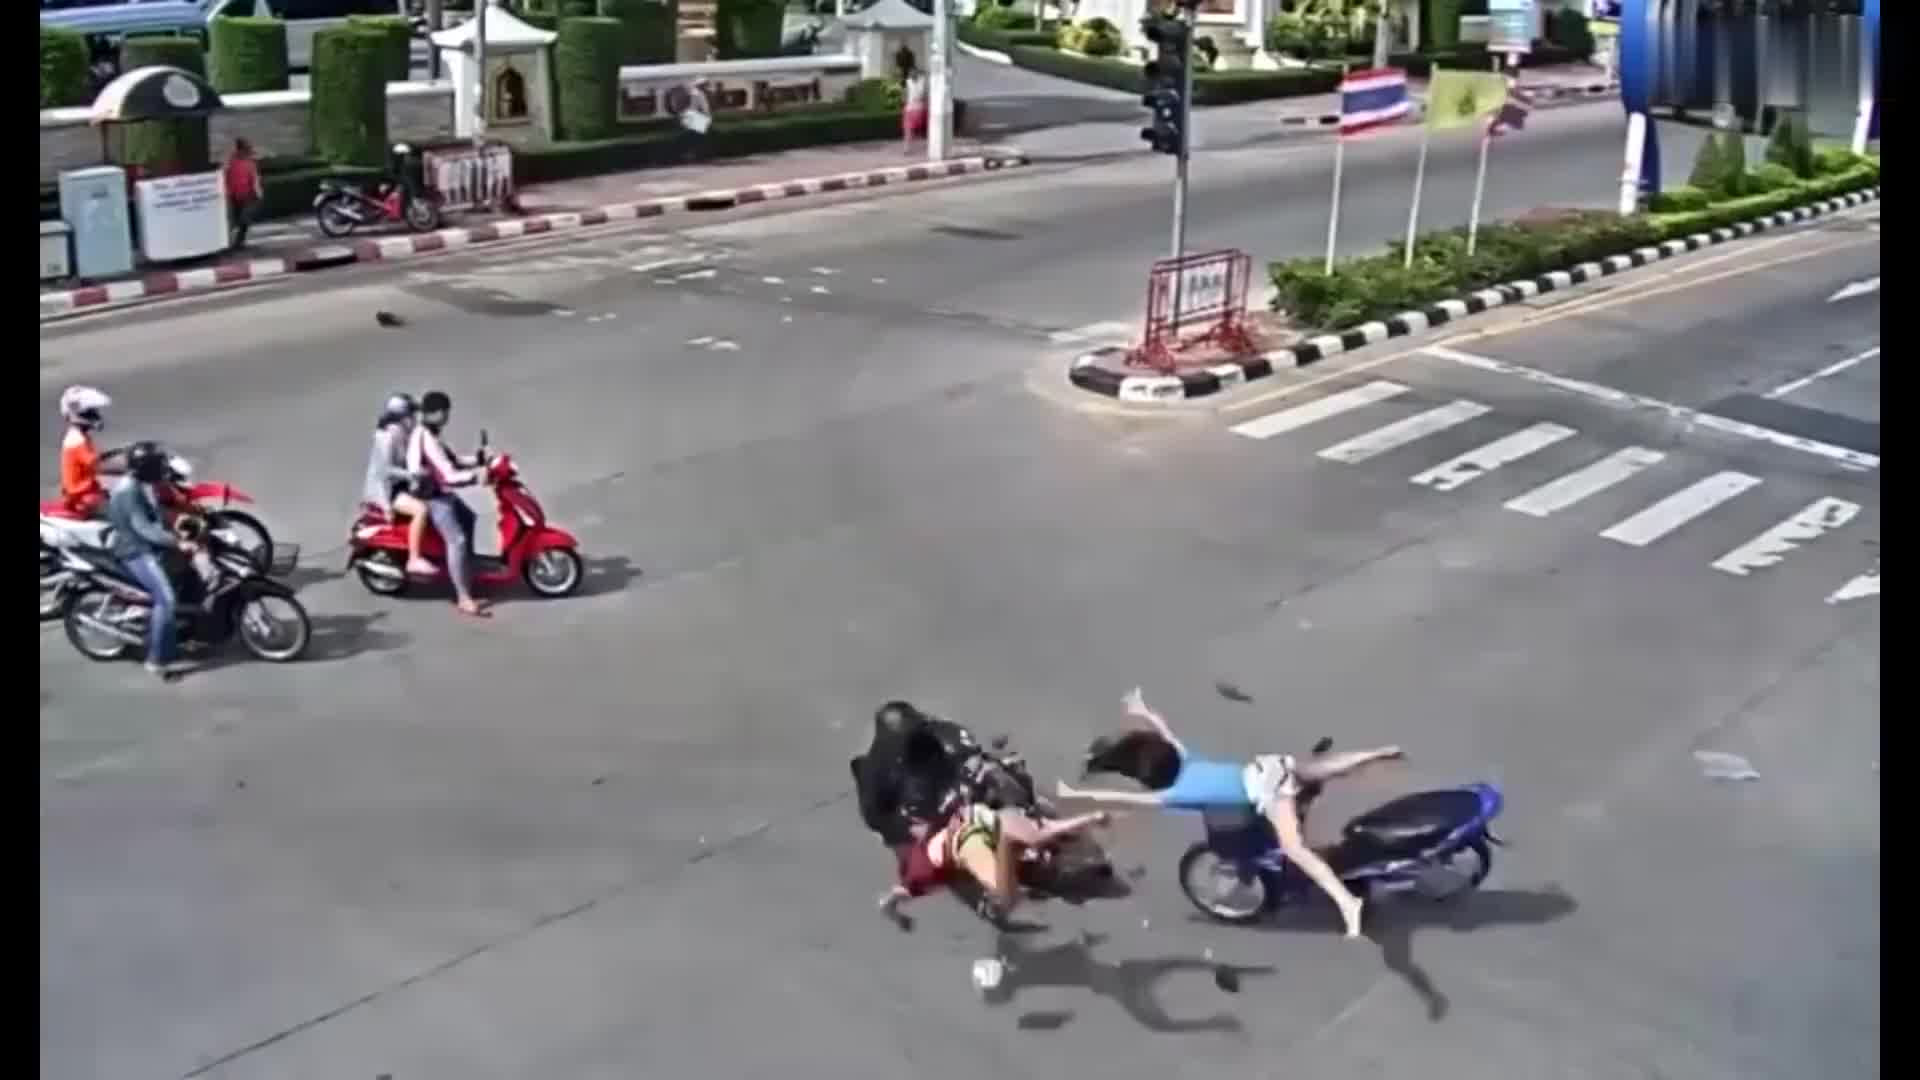

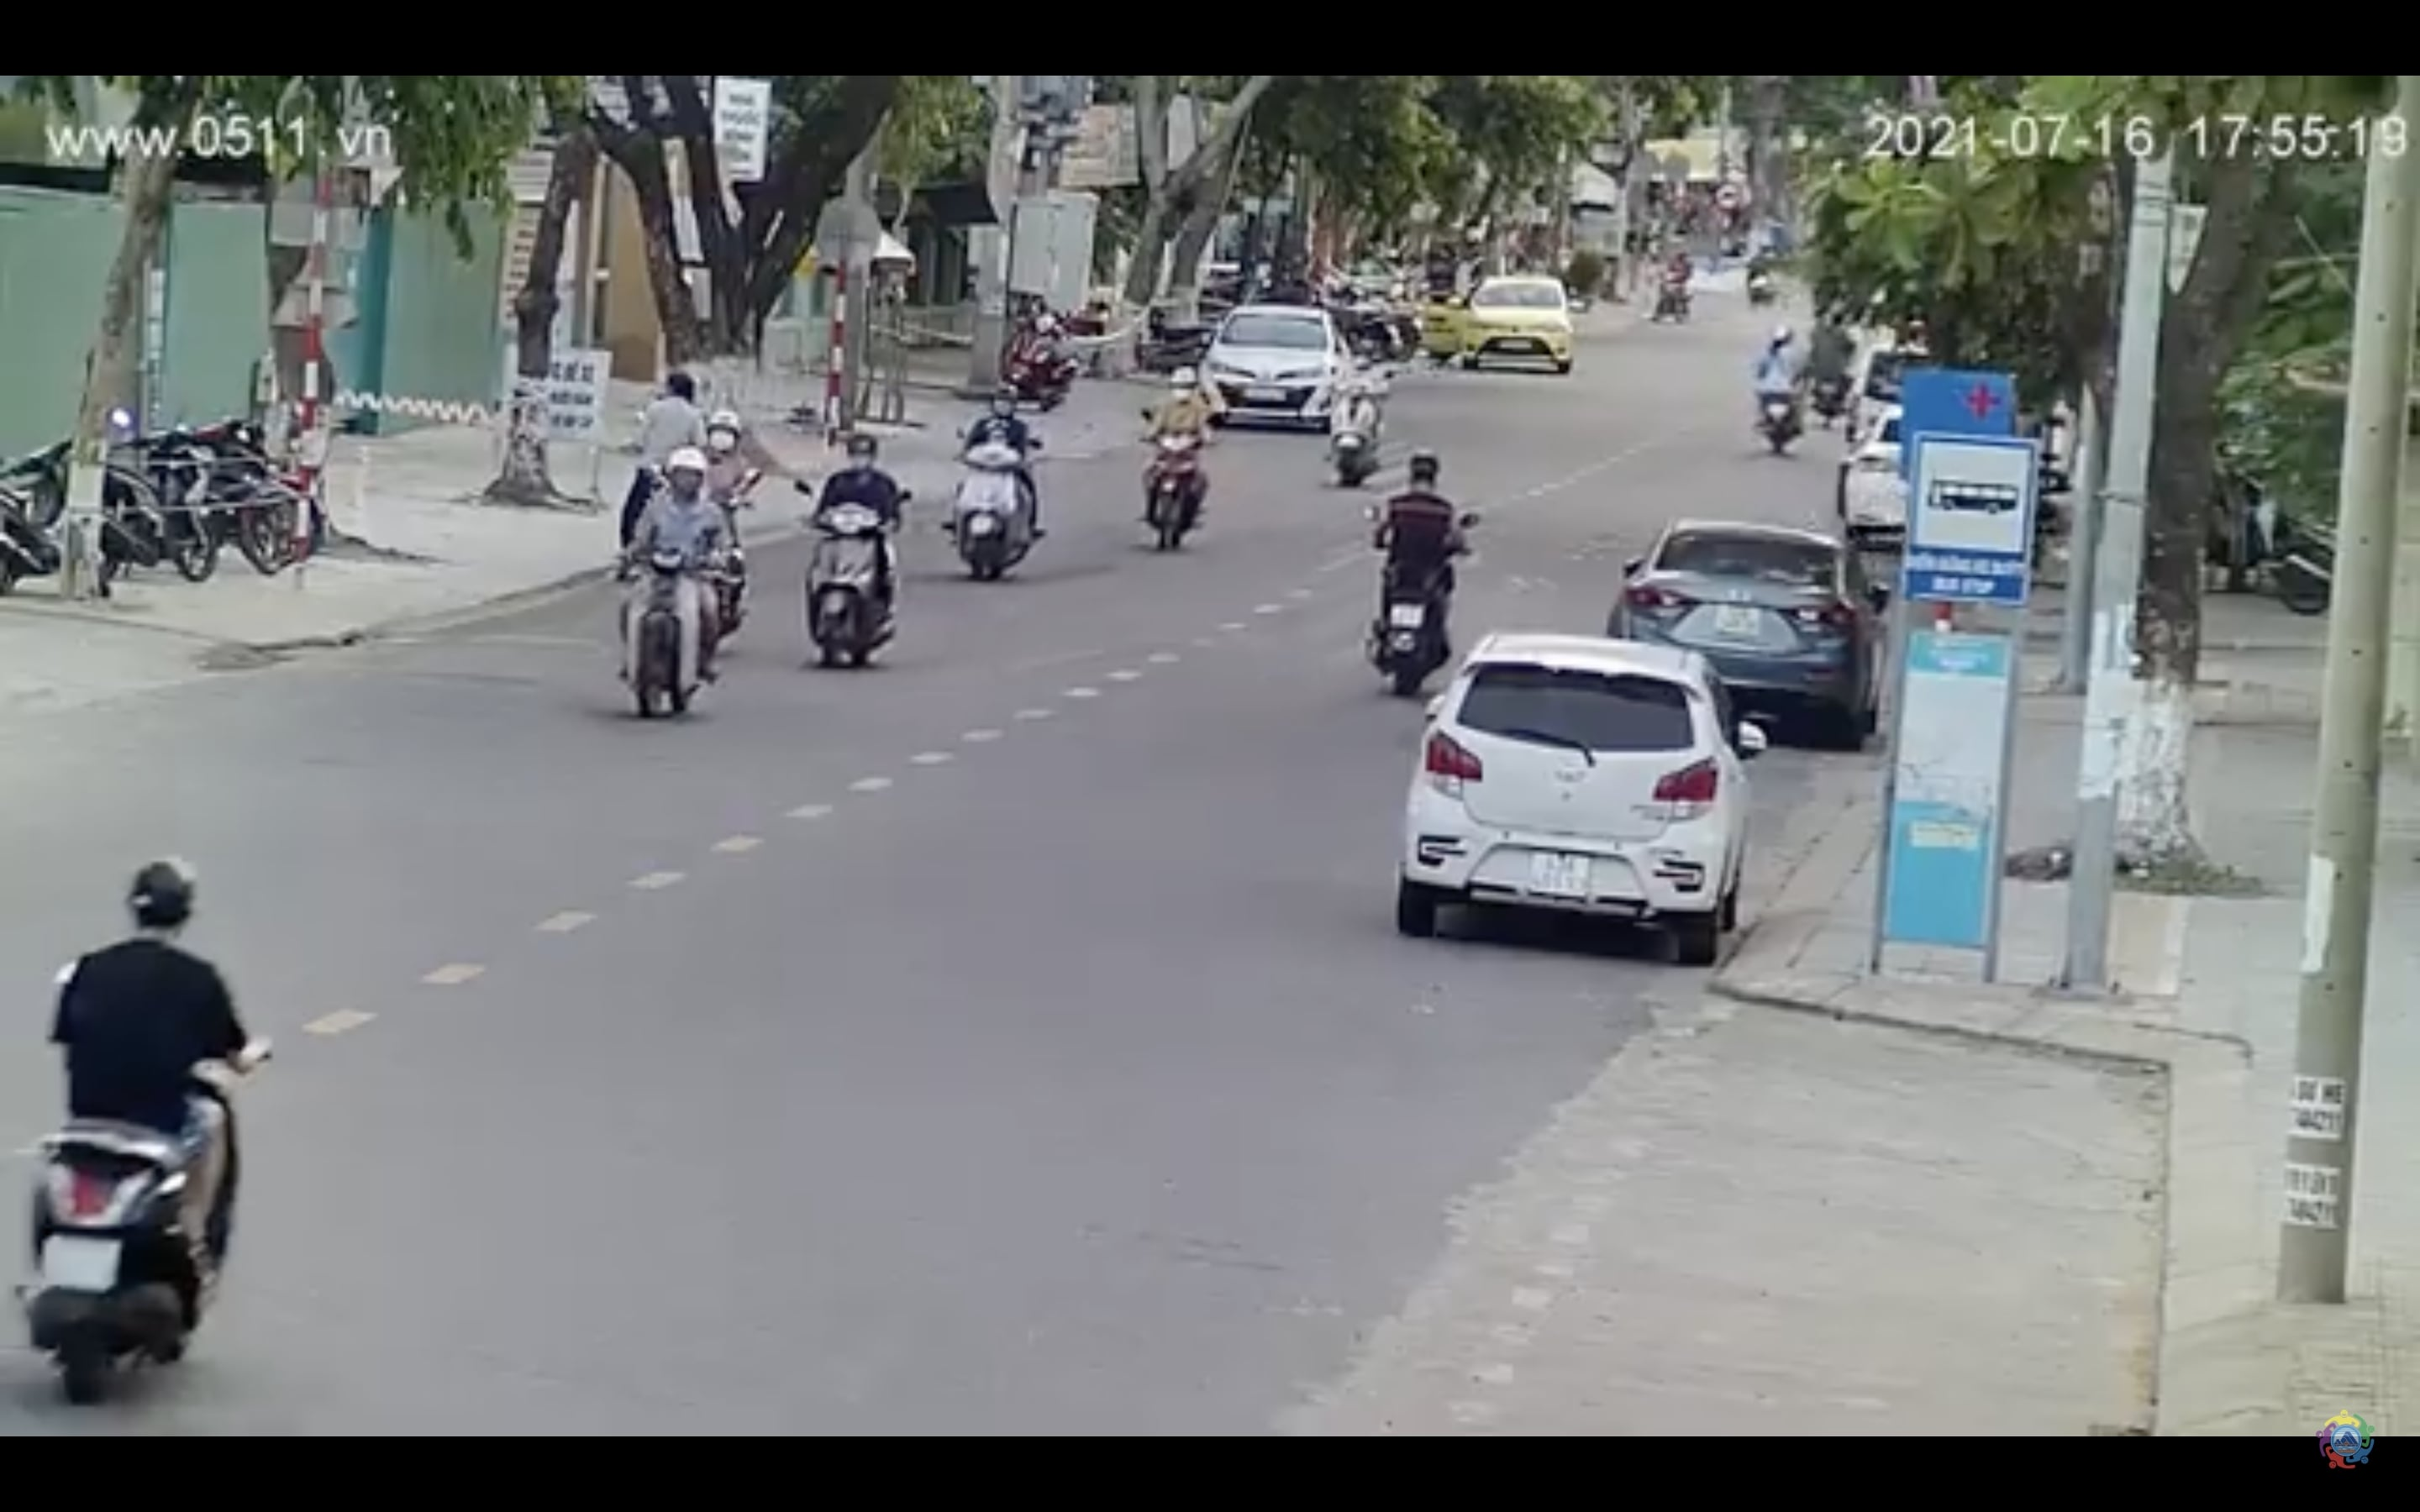

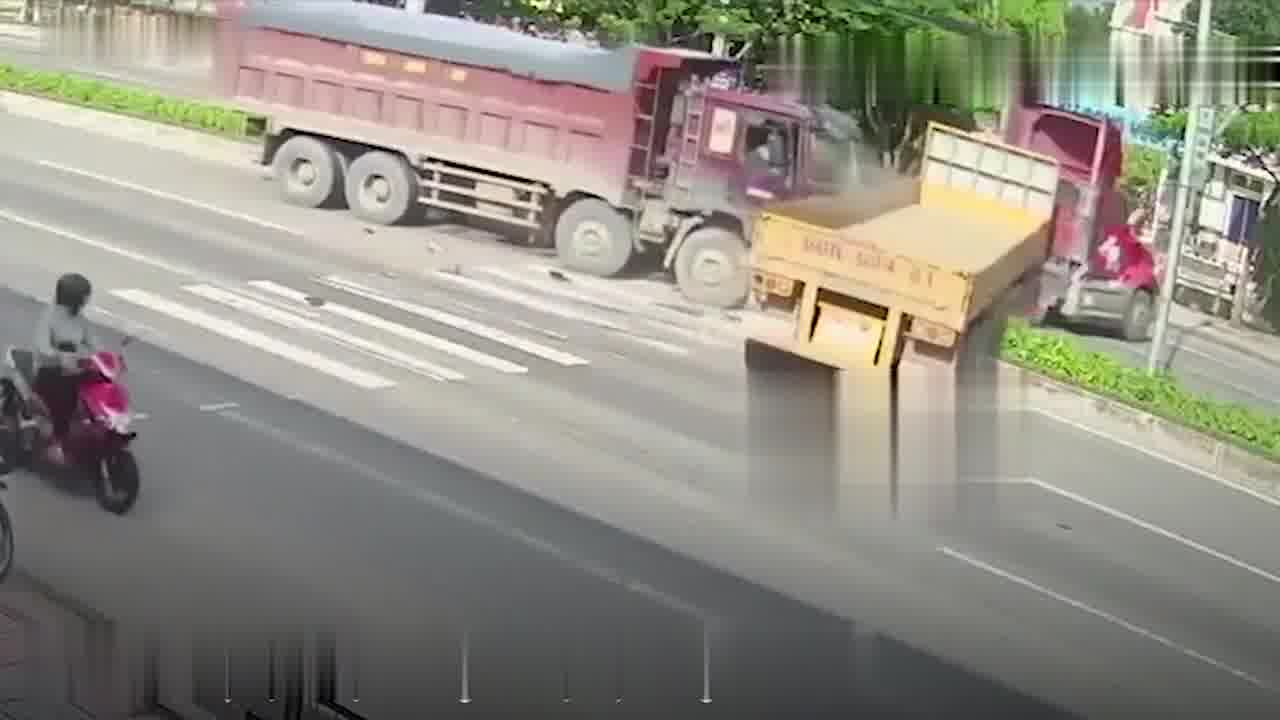

In [ ]:
if len(false_) > 0:
  for img in false_:  
    display(Image(img, width = 448, height = 448))

# **Mô hình dùng kỹ thuật Transfer Learning**

# 1. Xây dựng mô hình

Ta cũng phân chia tập train và tập valid theo tỉ lệ 8/2 như các mô hình trước 

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=0.20)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR, subset="training", shuffle=True, target_size=IMAGE_SHAPE)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR, subset="validation", shuffle=True, target_size=IMAGE_SHAPE)

Found 3101 images belonging to 2 classes.
Found 774 images belonging to 2 classes.


Load mô hình ***MobileNetV2*** đã được ***pre-trained*** từ ***TensorFlow Hub.***

Link tham khảo: https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4

In [ ]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
 hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", output_shape=[1280], 
                trainable=False), tf.keras.layers.Dropout(0.4), tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

# Stop training if 'val_loss' stops improving for over 5 epochs <=> Fix Overfitting problem
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)

# Save the best model to .h5 file
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model3.h5',monitor='val_loss',save_best_only=True,verbose=1)

hist = model.fit(train_generator, epochs=20, verbose=1, steps_per_epoch=steps_per_epoch, 
                 validation_data=valid_generator, validation_steps=val_steps_per_epoch, callbacks=[early_stopping,best_model]).history

Epoch 1/20
97/97 [==============================] - 140s 1s/step - loss: 0.3981 - acc: 0.8233 - val_loss: 0.1567 - val_acc: 0.9509

Epoch 00001: val_loss improved from inf to 0.15670, saving model to best_model3.h5
Epoch 2/20
97/97 [==============================] - 132s 1s/step - loss: 0.1619 - acc: 0.9426 - val_loss: 0.1131 - val_acc: 0.9677

Epoch 00002: val_loss improved from 0.15670 to 0.11311, saving model to best_model3.h5
Epoch 3/20
97/97 [==============================] - 133s 1s/step - loss: 0.1197 - acc: 0.9600 - val_loss: 0.0958 - val_acc: 0.9716

Epoch 00003: val_loss improved from 0.11311 to 0.09581, saving model to best_model3.h5
Epoch 4/20
97/97 [==============================] - 133s 1s/step - loss: 0.0983 - acc: 0.9658 - val_loss: 0.0876 - val_acc: 0.9755

Epoch 00004: val_loss improved from 0.09581 to 0.08763, saving model to best_model3.h5
Epoch 5/20
97/97 [==============================] - 132s 1s/step - loss: 0.0868 - acc: 0.9729 - val_loss: 0.0793 - val_acc: 0.97

Load mô hình tốt nhất sau khi train (***File best_model3.h5***)

In [ ]:
# Load the best model
try:
  model = tf.keras.models.load_model(filepath="/content/best_model3.h5",custom_objects={'KerasLayer':hub.KerasLayer})
  print("Load Model Successfully!")
except:
  print("Failed to load model! Please check again!")

Load Model Successfully!


Đánh giá mô hình trên tập valid

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

25/25 [==============================] - 27s 1s/step - loss: 0.0507 - acc: 0.9845
Final loss: 0.05
Final accuracy: 98.45%


# 2. Trực quan mô hình

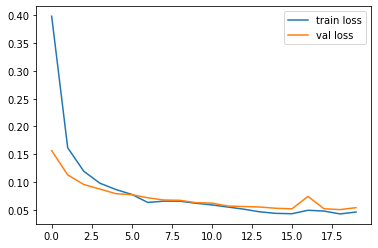

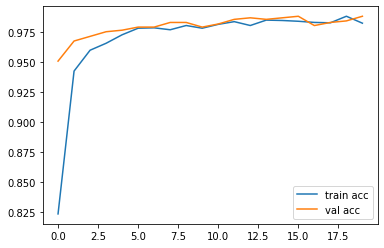

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
r = hist
plt.plot(r['loss'], label='train loss')
plt.plot(r['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss_pretrained_model')

# plot the accuracy
plt.plot(r['acc'], label='train acc')
plt.plot(r['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc_pretrained_model')

# Dự đoán của mô hình trên tập test

Total correct prediction:  426
Total incorrect prediction:  6


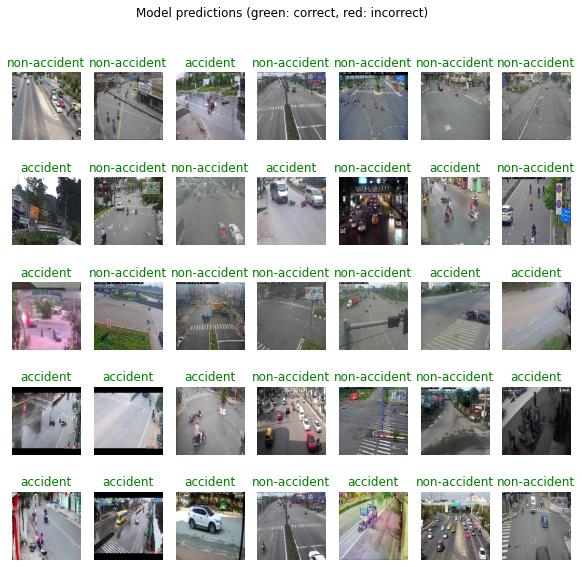

In [ ]:
prePath = "/content/test/"
test_ = random.sample(os.listdir(prePath),total_test)
random.shuffle(test_)
false_ = []

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for _ in range(len(test_)):
  if _ < 35:
    plt.subplot(5, 7, _+1)
  true_label_ = len(test_[_].split("_"))
  img_= image.load_img(prePath + test_[_], target_size = (224,224))
  if _ < 35:
    plt.imshow(img_)
  img_ = image.img_to_array(img_)
  img_= img_/255
  img_ = np.expand_dims(img_, axis = 0)
  pre_ = 2 if np.argmax(model.predict(img_), axis=-1)[0] == 0 else 3
  if pre_ == true_label_:
    color = "green"
  else:
    color = "red"
    false_.append(prePath+test_[_])
  plt.title("accident" if pre_ == 2 else "non-accident", color=color)
  plt.axis('off')
  plt.suptitle("Model predictions (green: correct, red: incorrect)")
print("Total correct prediction: ",total_test-len(false_))
print("Total incorrect prediction: ",len(false_))

# Hiển thị các ảnh dự đoán sai

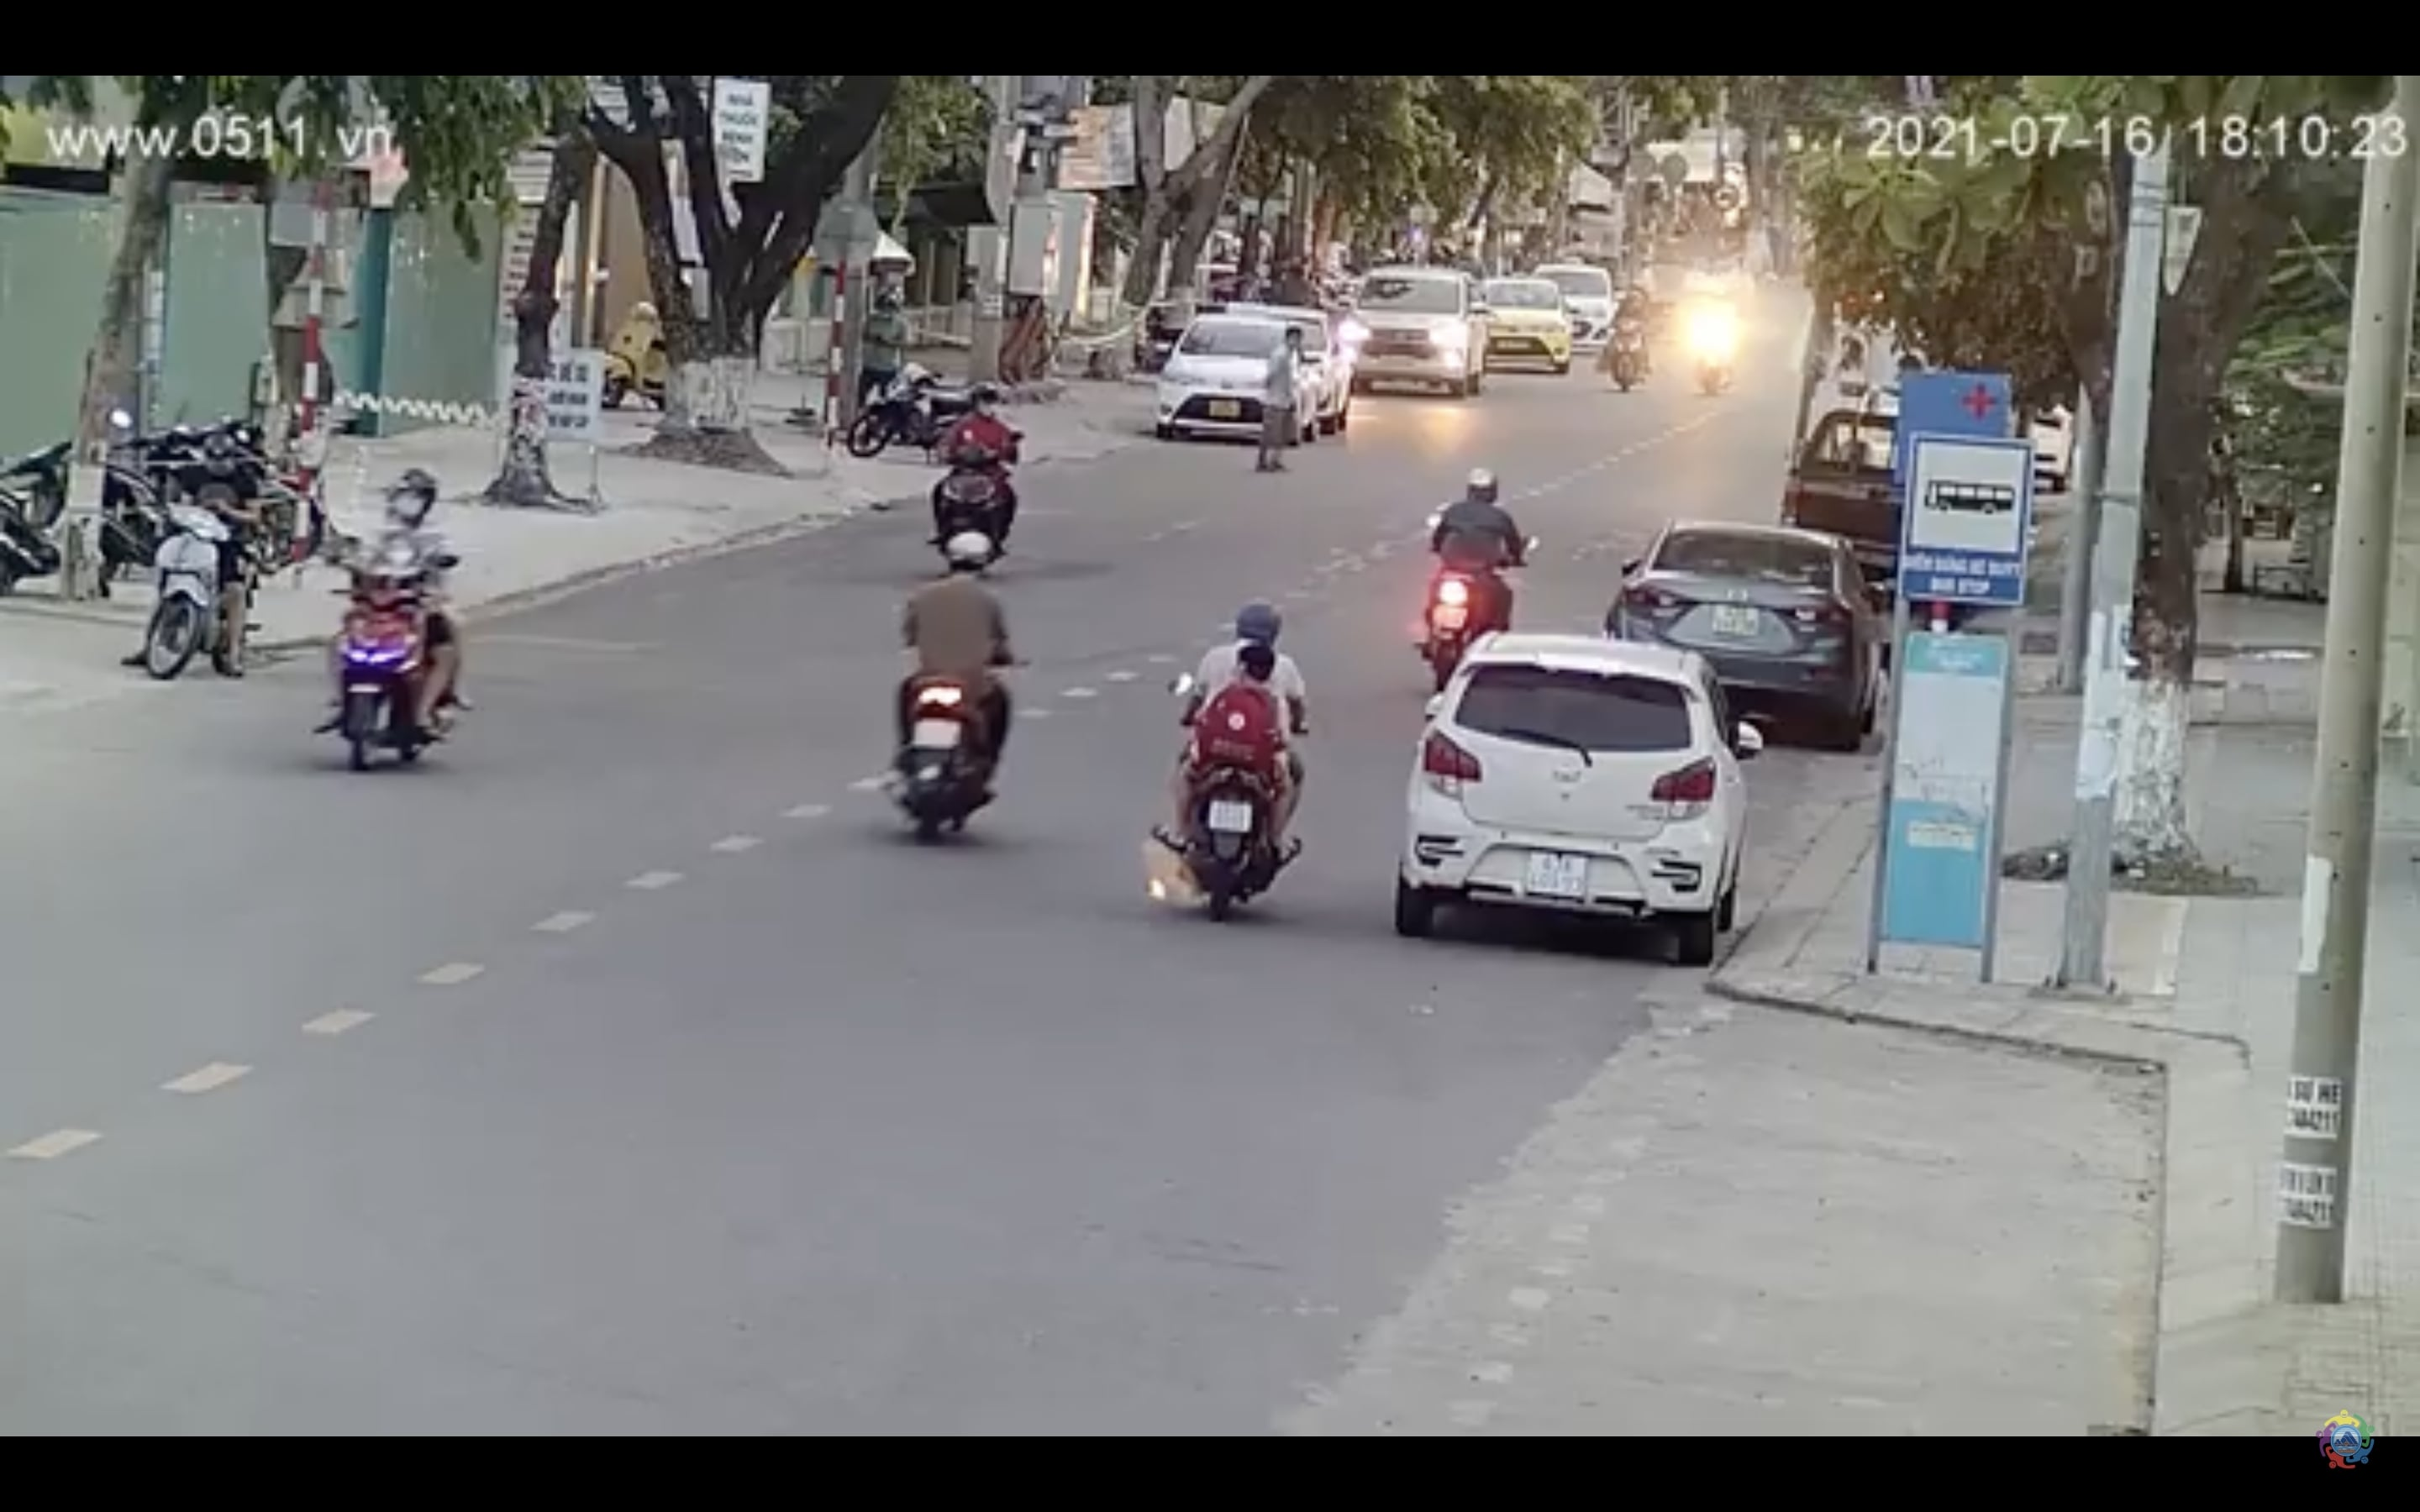

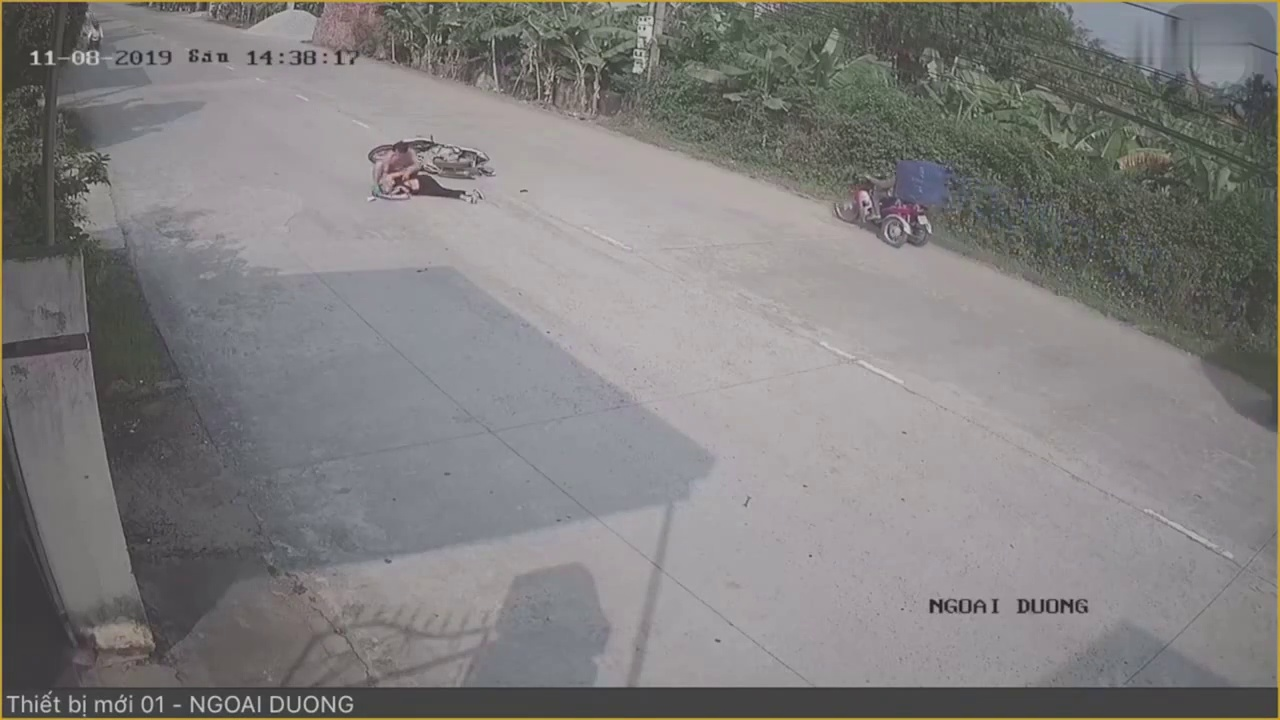

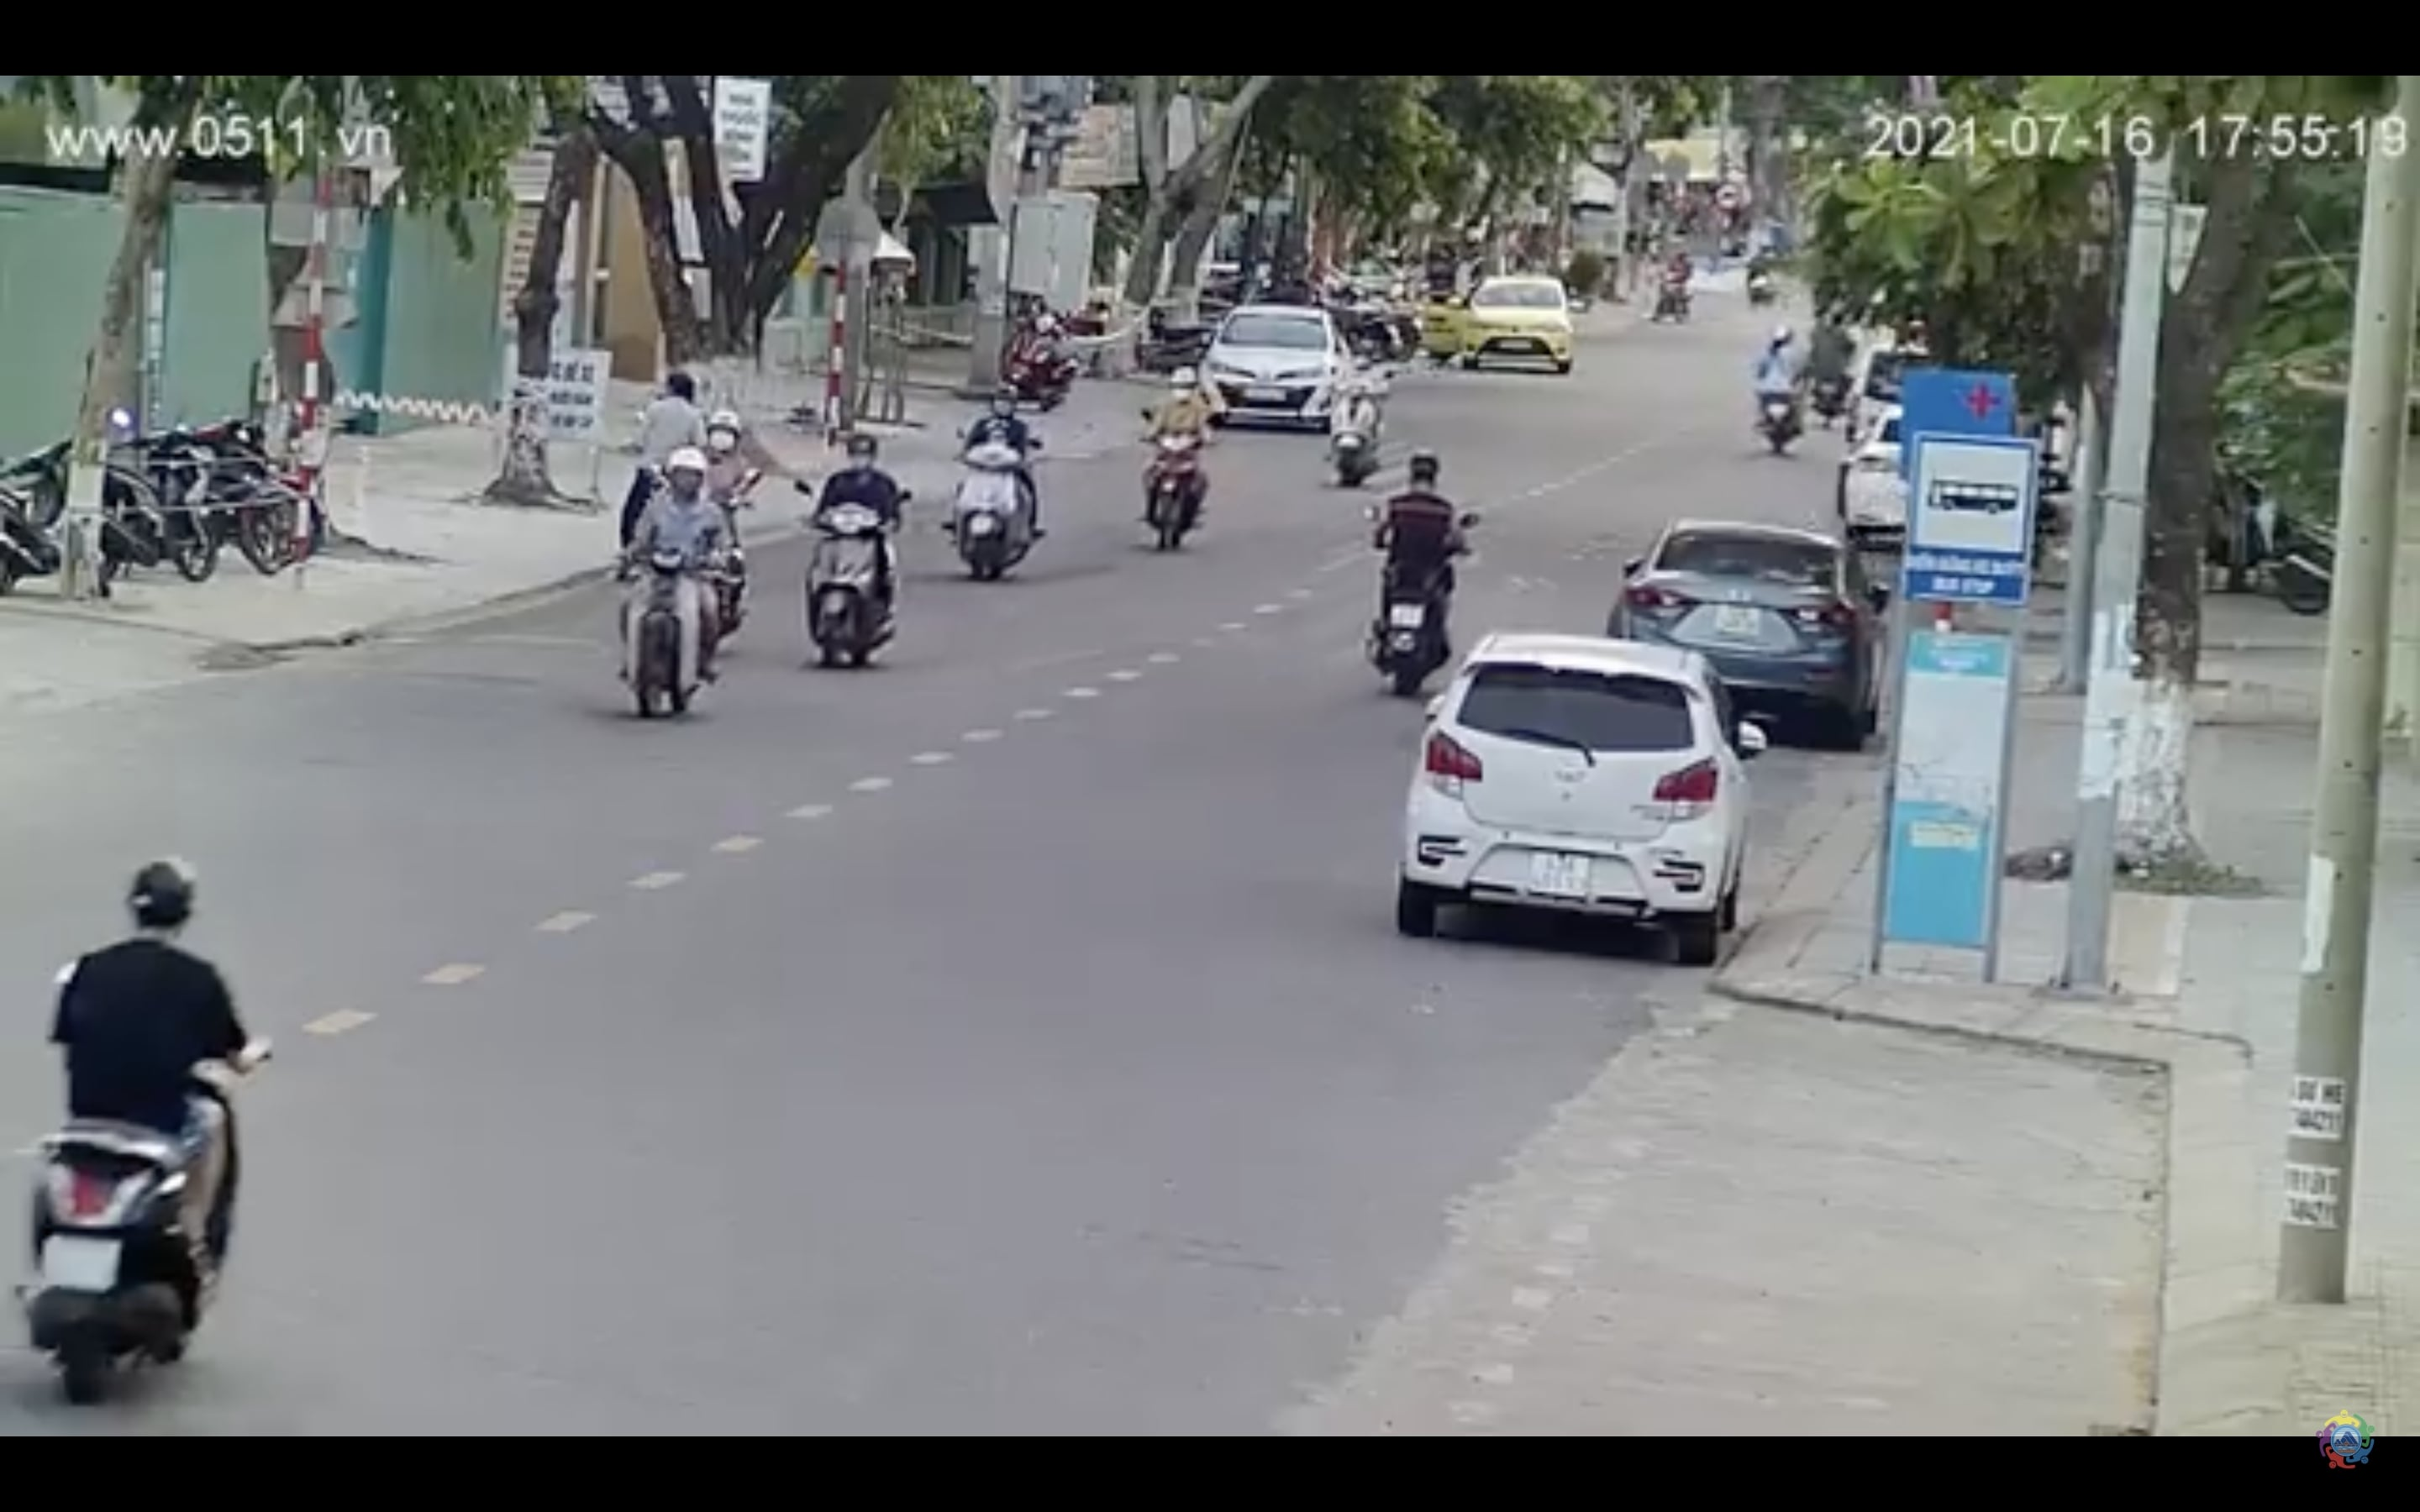

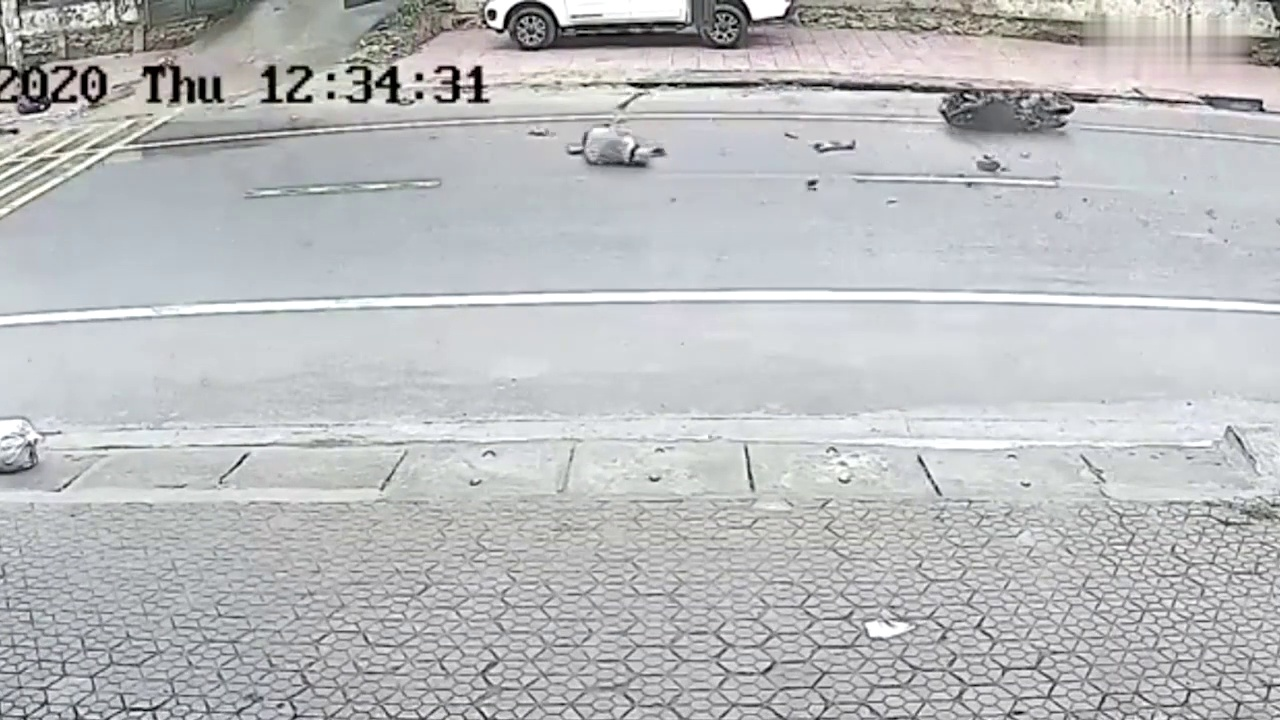

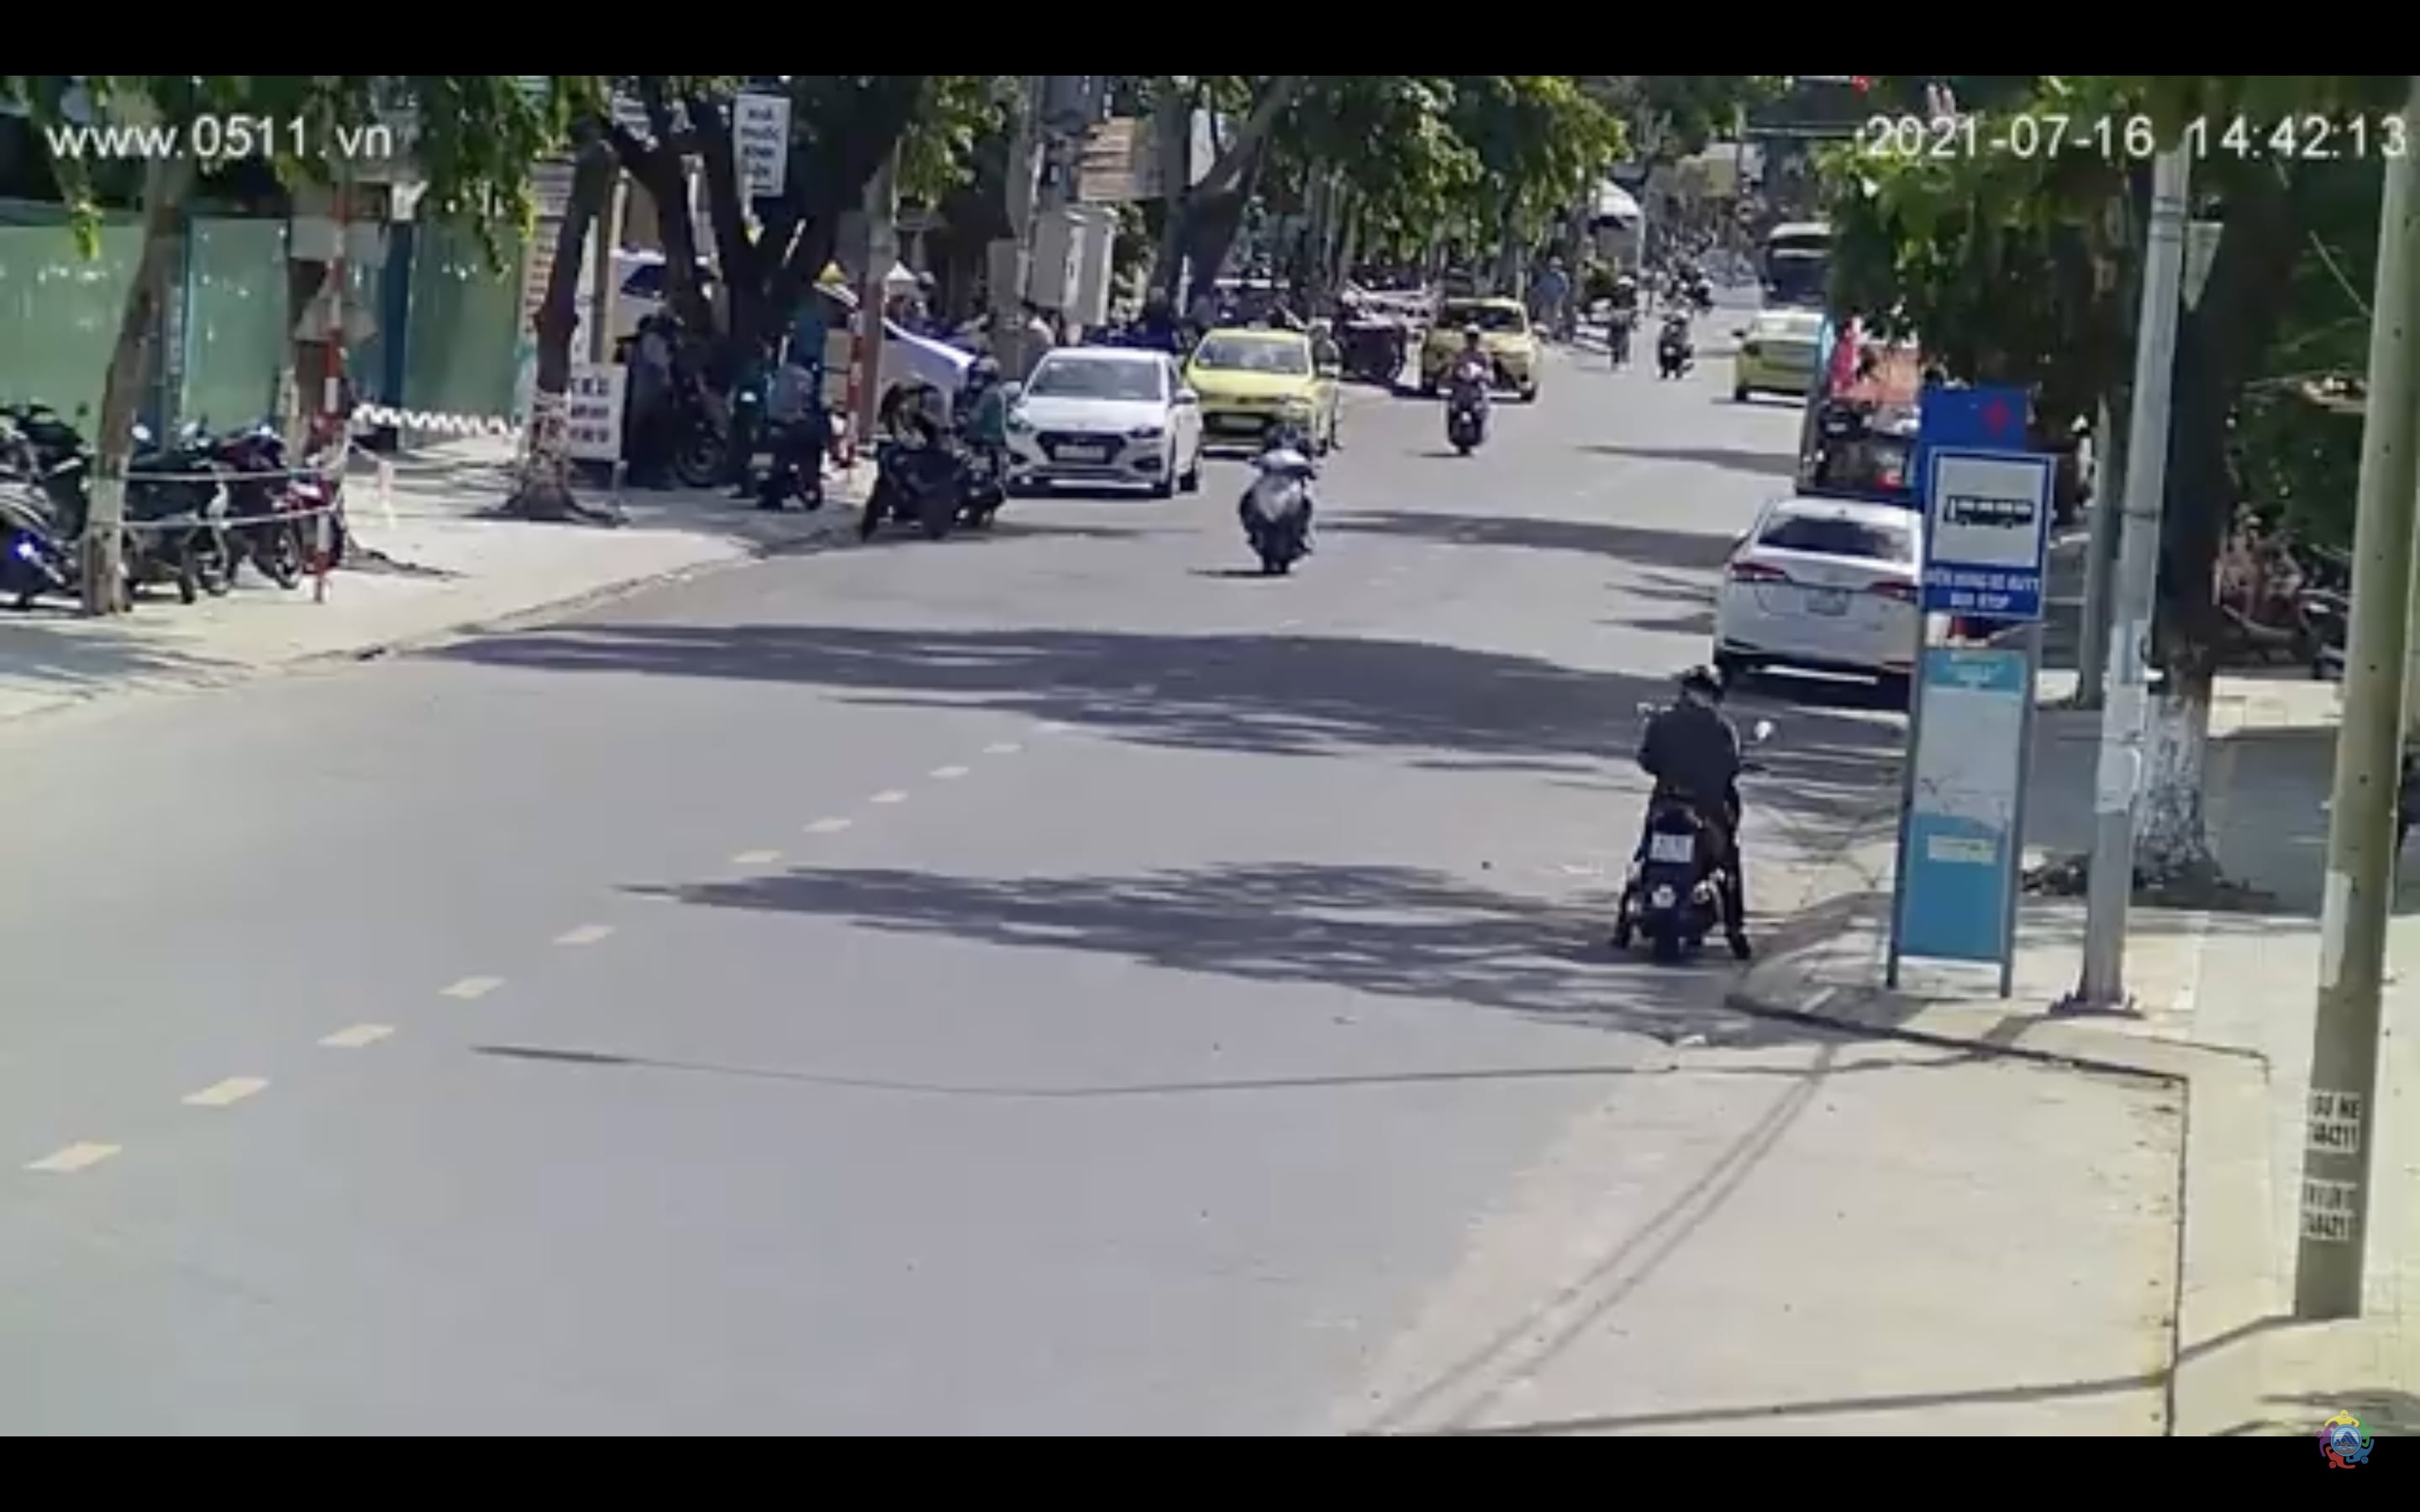

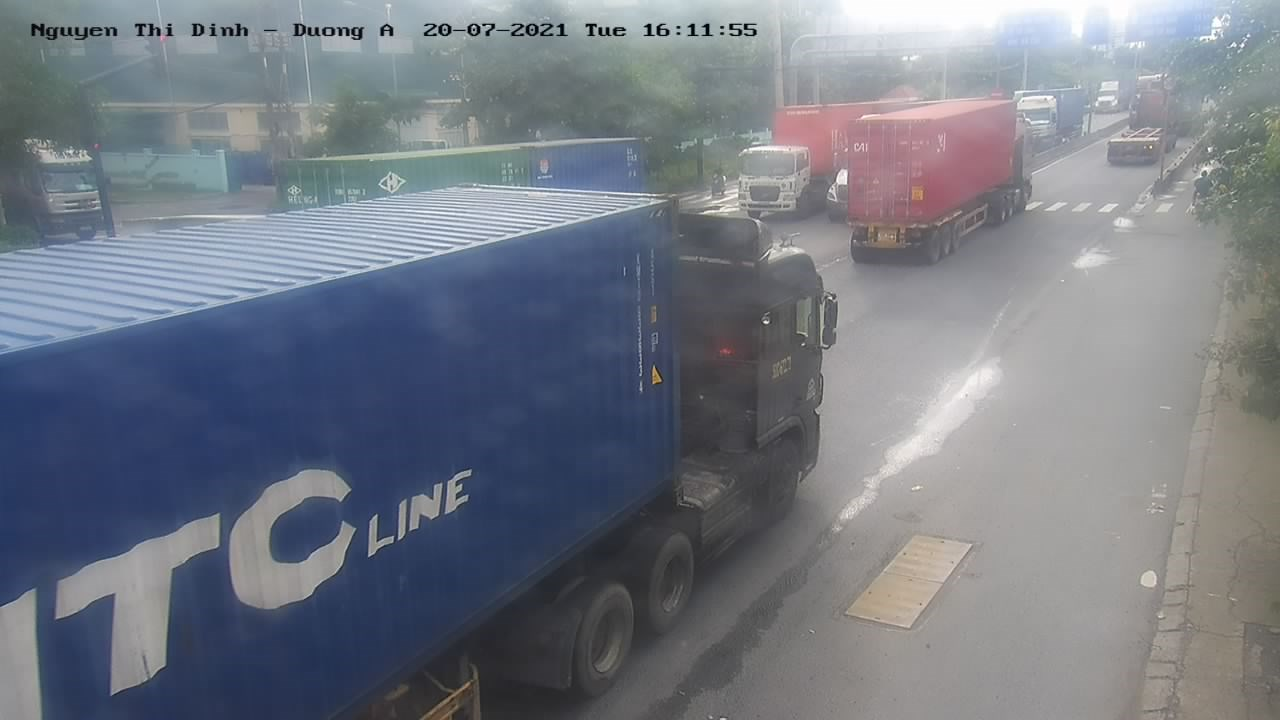

In [ ]:
if len(false_) > 0:
  for img in false_:  
    display(Image(img, width = 448, height = 448))